In [105]:
import json
import datetime as dt
from typing import Dict

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from TETrading.trading_system.trading_system import TradingSystem
from TETrading.position.position_sizer.ext_position_sizer import ExtPositionSizer

from system_development.data_utils.indicator_feature_workshop.technical_features.standard_indicators \
    import apply_rsi

from instruments_mongo_db.instruments_mongo_db import InstrumentsMongoDb
from tet_mongo_db.systems_mongo_db import TetSystemsMongoDb

from securities_db_py_dal.dal import price_data_get_req

In [106]:
def regression_entry_func(df: pd.DataFrame, *args, entry_args=None):
    return df['pred'].iloc[-1] > 0, 'long'

def regression_exit_func(
    df: pd.DataFrame, trail, trailing_exit_price, entry_price, periods_in_pos,
    *args, exit_args=None
):
    return df['pred'].iloc[-1] < 0, trail, trailing_exit_price

In [107]:
def create_regression_models(
    data_dict: Dict[str, pd.DataFrame], *args, target_col='Close', target_period=1
):
    models_df_dict: Dict[str, pd.DataFrame] = {}
    for symbol, df in dict(data_dict).items():
        print(symbol)

        df['Target'] = df[target_col].pct_change(periods=target_period).shift(-target_period)
        df.dropna(inplace=True)

        y_df = df['Target']

        X_df = df.copy()
        X_df.drop(
            columns=[
                'Open', 'High', 'Low', 'Close', 'Pct_chg', 
                'Target', 'symbol', 
                'Open_benchmark', 'High_benchmark', 'Low_benchmark', 
                'Close_benchmark', 'Volume_benchmark', 'symbol_benchmark'
            ],
            axis=1, inplace=True
        )

        X = X_df.to_numpy()
        y = y_df.to_numpy()

        ts_split = TimeSeriesSplit(n_splits=3)

        models_df_dict[symbol] = None
        try:
            for tr_index, val_index in ts_split.split(X):
                X_train, X_test = X[tr_index], X[val_index]
                y_train, y_test = y[tr_index], y[val_index]
                steps = [
                    ('scaler', StandardScaler()),
                    ('linreg', LinearRegression())
                ]
                pipeline = Pipeline(steps)
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)
                pred_df = df.iloc[-len(X_test):].copy()
                pred_df['pred'] = y_pred.tolist()
                r_squared = r2_score(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                print(f'R^2: {r_squared}')
                print(f'RMSE: {rmse}')
                print(pipeline.score(X, y))
                print(pipeline.score(X_train, y_train))
                print(pipeline.score(X_test, y_test))
                print()
            if models_df_dict[symbol] is None:
                models_df_dict[symbol] = pred_df
            else:
                models_df_dict[symbol].append(pred_df)
        except ValueError:
            print('ValueError')
            print(symbol, len(df))
            input('Enter to proceed')

    return models_df_dict

In [108]:
def preprocess_data(data_dict: Dict[str, pd.DataFrame], df_benchmark: pd.DataFrame):
    for symbol, df in dict(data_dict).items():
        if df.empty:
            print(symbol, 'DataFrame empty')
            del data_dict[symbol]
        else:
            data_dict[symbol] = pd.merge_ordered(
                df, df_benchmark, on='Date', how='inner',
                suffixes=('', '_benchmark')
            )
            data_dict[symbol].fillna(method='ffill', inplace=True)
            data_dict[symbol]['Date'] = pd.to_datetime(data_dict[symbol]['Date'])
            data_dict[symbol].set_index(['Date'], inplace=True)

            data_dict[symbol]['Pct_chg'] = data_dict[symbol]['Close'].pct_change().mul(100)
            data_dict[symbol]['Lag1'] = data_dict[symbol]['Pct_chg'].shift(1)
            data_dict[symbol]['Lag2'] = data_dict[symbol]['Pct_chg'].shift(2)
            data_dict[symbol]['Lag5'] = data_dict[symbol]['Pct_chg'].shift(5)
            data_dict[symbol]['sma_fast'] = data_dict[symbol]['Close'].rolling(8).mean()
            data_dict[symbol]['sma_slow'] = data_dict[symbol]['Close'].rolling(16).mean()
            data_dict[symbol]['sma_diff'] = data_dict[symbol]['sma_fast'] - data_dict[symbol]['sma_slow']
            data_dict[symbol]['crs'] = data_dict[symbol]['Close'] / data_dict[symbol]['Close_benchmark']
            data_dict[symbol]['crs_sma_fast'] = data_dict[symbol]['crs'].rolling(8).mean()
            data_dict[symbol]['crs_sma_slow'] = data_dict[symbol]['crs'].rolling(16).mean()
            data_dict[symbol]['crs_sma_diff'] = data_dict[symbol]['crs_sma_fast'] - data_dict[symbol]['crs_sma_slow']
            apply_rsi(data_dict[symbol], period_param=8)
            apply_rsi(data_dict[symbol], period_param=8, col_name='Close_benchmark', suffix='_benchmark')
            data_dict[symbol].dropna(inplace=True)

    return data_dict

ESSITY_B DataFrame empty
EVO DataFrame empty
SINCH DataFrame empty
SAND
R^2: -0.013087506953623373
RMSE: 0.044388207568898407
-0.08804034424084262
0.061274310704775736
-0.013087506953623373

R^2: 0.03970387980911427
RMSE: 0.04345574789941055
0.003213078101084954
0.06217183816644822
0.03970387980911427

R^2: -0.23308166536260488
RMSE: 0.042851893068630895
-0.008820772404190658
0.06342997932964622
-0.23308166536260488

SHB_A
R^2: -0.09968973534962644
RMSE: 0.0389277347195756
-0.07768521360779923
0.06336336503816553
-0.09968973534962644

R^2: 0.0017096869334066733
RMSE: 0.03854154148214292
0.0011761270837048476
0.023191865068465267
0.0017096869334066733

R^2: -0.2779455932649626
RMSE: 0.029876352958424723
-0.023019563499297124
0.031024908709235688
-0.2779455932649626

SCA_B
R^2: -0.027666321003611882
RMSE: 0.035908674824466205
-0.07279893974819496
0.047533500702825804
-0.027666321003611882

R^2: -0.004725956850330615
RMSE: 0.02936933188022807
-0.017571121334533535
0.014490616060647166
-0.

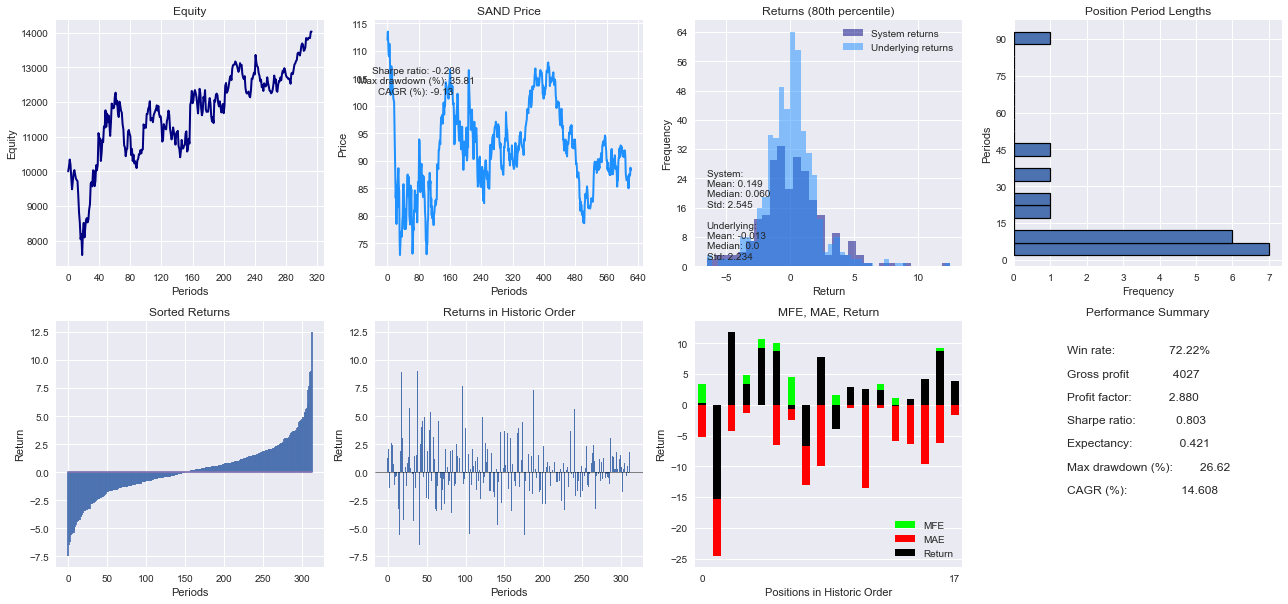


Entry index 4: 63.433, 2011-07-12 00:00:00+00:00
Unrealised P/L sequence: [0.57, 0.63, -0.33, -0.5, -1.13, -0.13, 1.83, 3.07, 3.57]
Market to market returns: [0.89, 0.1, -1.51, -0.26, -1.01, 1.61, 3.11, 1.89, 0.75]
Unrealised return sequence: [0.89, 1.0, -0.53, -0.79, -1.79, -0.21, 2.89, 4.83, 5.62]
Exit index 12: 67.000, 2011-07-22 00:00:00+00:00
Realised return: 5.62

Entry index 13: 65.667, 2011-07-25 00:00:00+00:00
Unrealised P/L sequence: [-0.03, 0.07, -0.27, 0.03, 0.5, -0.4, -1.2]
Market to market returns: [-0.05, 0.15, -0.51, 0.46, 0.71, -1.36, -1.23]
Unrealised return sequence: [-0.05, 0.1, -0.41, 0.05, 0.76, -0.61, -1.83]
Exit index 19: 64.467, 2011-08-02 00:00:00+00:00
Realised return: -1.83

Entry index 28: 59.567, 2011-08-15 00:00:00+00:00
Unrealised P/L sequence: [0.47, -0.17, -0.27, -4.13, -4.97, -4.73, -4.0, -3.03, -3.63, -3.6, -2.37, -2.2, -1.47, -0.63, -3.17, -5.67, -6.97, -5.47, -4.73, -7.27, -9.57, -8.2, -7.0, -4.53, -4.2, -6.3, -4.1, -4.57, -6.5, -6.23, -4.23, -2.9

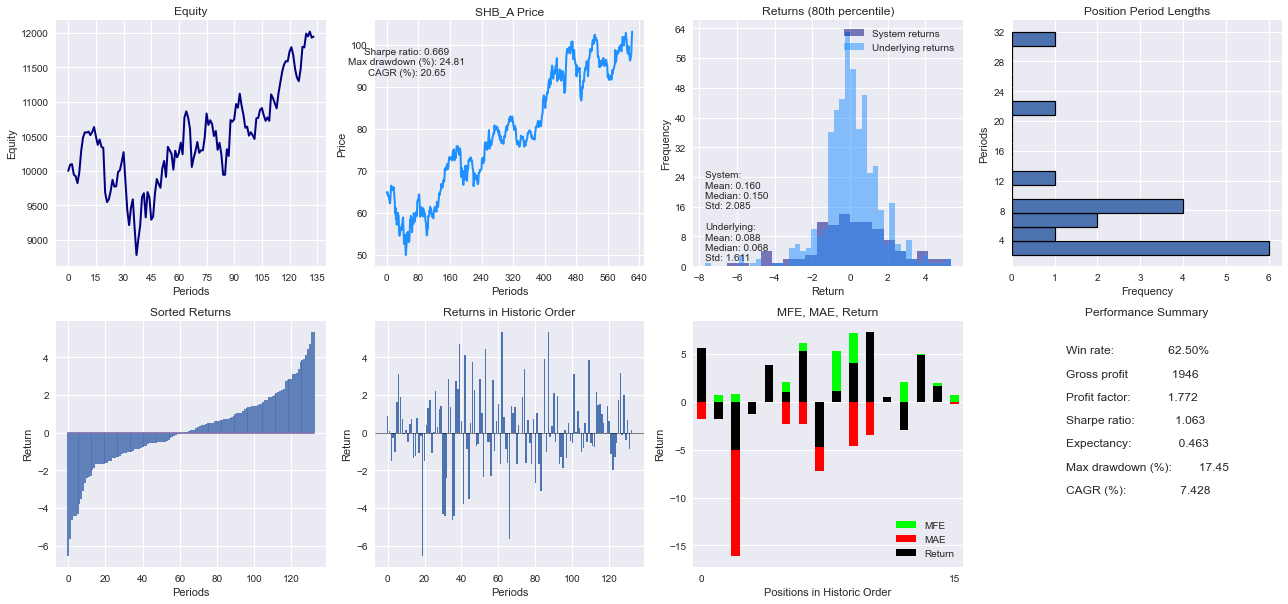


Entry index 4: 18.123, 2011-07-13 00:00:00+00:00
Unrealised P/L sequence: [0.17, 0.1, -0.24, -0.57, -0.17, -0.01, 0.83, 1.18, 1.04]
Market to market returns: [0.96, -0.39, -1.9, -1.83, 2.27, 0.91, 4.62, 1.88, -0.74]
Unrealised return sequence: [0.96, 0.56, -1.35, -3.15, -0.96, -0.06, 4.56, 6.53, 5.74]
Exit index 12: 19.163, 2011-07-25 00:00:00+00:00
Realised return: 5.74

Entry index 14: 18.990, 2011-07-27 00:00:00+00:00
Unrealised P/L sequence: [0.08, 0.01, -0.27, -0.41, -0.39, -0.54, -1.32, -1.31, -1.61]
Market to market returns: [0.43, -0.37, -1.45, -0.76, 0.11, -0.82, -4.2, 0.06, -1.73]
Unrealised return sequence: [0.43, 0.05, -1.4, -2.15, -2.04, -2.85, -6.93, -6.87, -8.49]
Exit index 22: 17.379, 2011-08-08 00:00:00+00:00
Realised return: -8.49

Entry index 23: 16.348, 2011-08-09 00:00:00+00:00
Unrealised P/L sequence: [0.09, -0.03, 0.93, 1.0]
Market to market returns: [0.56, -0.74, 5.87, 0.41]
Unrealised return sequence: [0.56, -0.19, 5.68, 6.11]
Exit index 26: 17.348, 2011-08-12

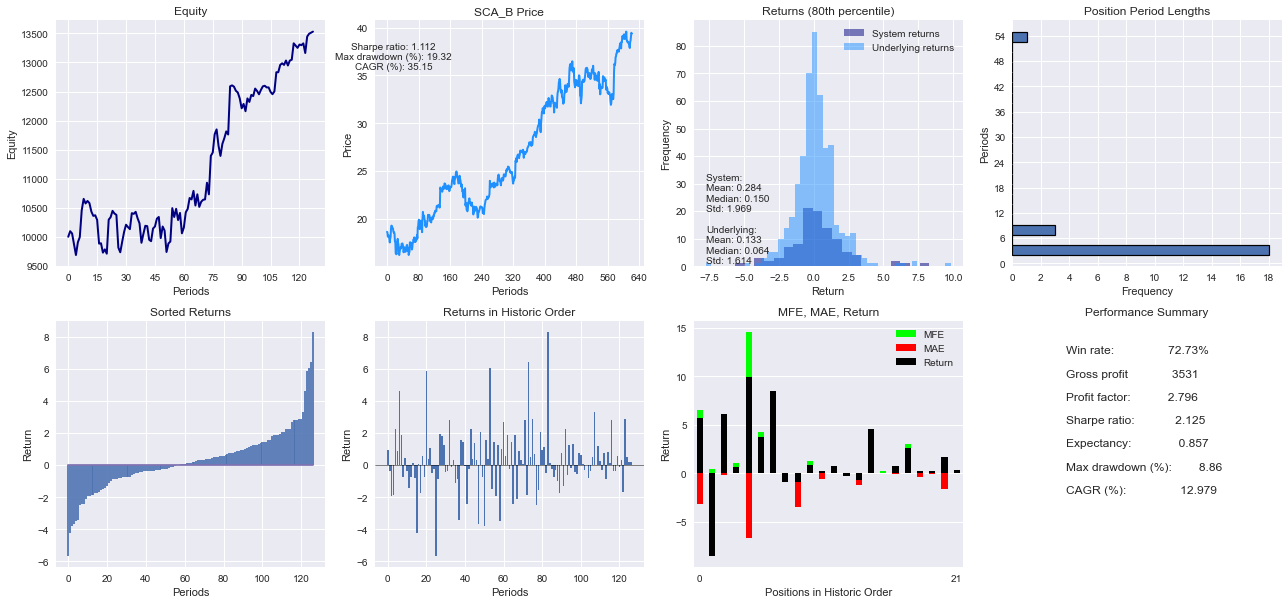


Entry index 4: 104.200, 2011-07-11 00:00:00+00:00
Unrealised P/L sequence: [-2.1, -3.5, -0.9, -2.4, -3.3, -3.8]
Market to market returns: [-2.02, -1.37, 2.58, -1.45, -0.88, -0.5]
Unrealised return sequence: [-2.02, -3.36, -0.86, -2.3, -3.17, -3.65]
Exit index 9: 100.400, 2011-07-18 00:00:00+00:00
Realised return: -3.65

Entry index 16: 110.300, 2011-07-27 00:00:00+00:00
Unrealised P/L sequence: [-0.9, 0.3, 0.3, -3.0, -6.9, -9.4, -17.1, -17.45, -23.35, -20.7, -25.9, -21.85, -19.65, -16.45, -16.7]
Market to market returns: [-0.82, 1.1, 0.0, -2.98, -3.63, -2.42, -7.63, -0.38, -6.35, 3.05, -5.8, 4.8, 2.49, 3.53, -0.27]
Unrealised return sequence: [-0.82, 0.27, 0.27, -2.72, -6.26, -8.52, -15.5, -15.82, -21.17, -18.77, -23.48, -19.81, -17.82, -14.91, -15.14]
Exit index 30: 93.600, 2011-08-16 00:00:00+00:00
Realised return: -15.14

Entry index 33: 83.350, 2011-08-19 00:00:00+00:00
Unrealised P/L sequence: [-2.5, -2.85, -2.9, -2.0, -1.55, -2.15, 0.1, 1.1]
Market to market returns: [-3.0, -0.4

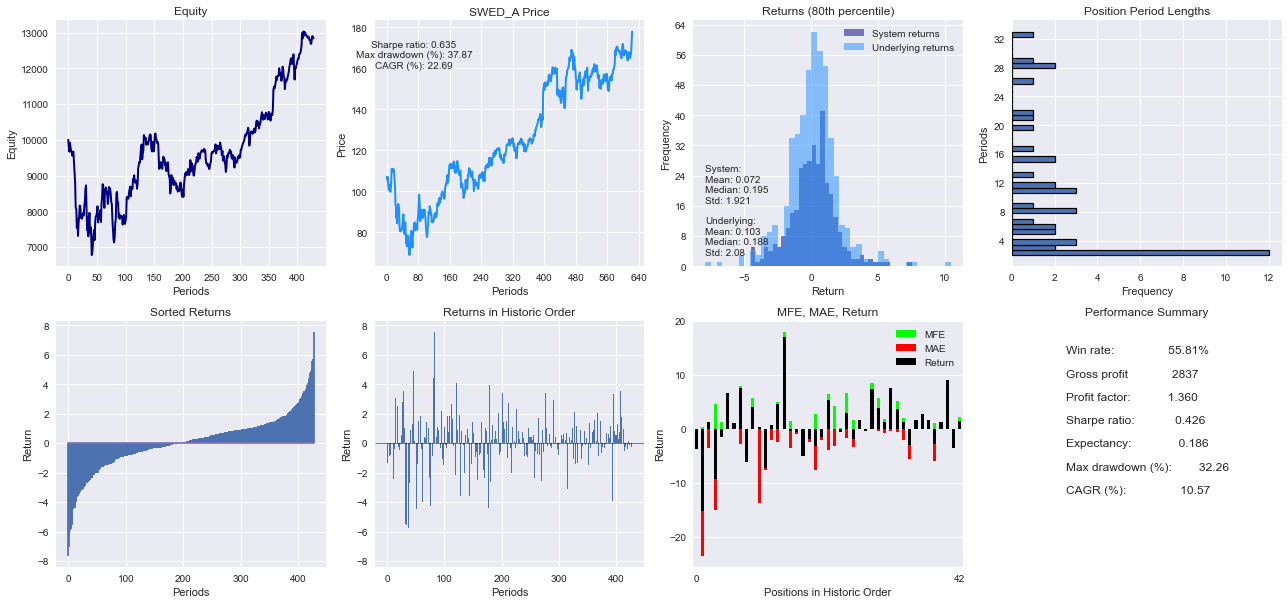


Entry index 5: 166.300, 2011-07-13 00:00:00+00:00
Unrealised P/L sequence: [3.9, 1.7, 0.7]
Market to market returns: [2.35, -1.29, -0.6]
Unrealised return sequence: [2.35, 1.02, 0.42]
Exit index 7: 167.000, 2011-07-15 00:00:00+00:00
Realised return: 0.42

Entry index 9: 161.200, 2011-07-19 00:00:00+00:00
Unrealised P/L sequence: [1.0, 2.1, -3.7, -4.9, -2.9, -4.3, -7.3, -8.4, -9.8, -11.5, -12.3, -13.9, -20.5, -21.0, -29.7, -22.6, -24.0, -22.7, -17.9, -20.2, -22.5, -24.8, -32.4, -35.2, -35.8, -34.7, -32.2, -34.5, -35.0, -32.3, -29.3, -25.7, -25.4]
Market to market returns: [0.62, 0.68, -3.55, -0.76, 1.28, -0.88, -1.91, -0.71, -0.92, -1.12, -0.53, -1.07, -4.48, -0.36, -6.21, 5.4, -1.01, 0.95, 3.47, -1.61, -1.63, -1.66, -5.57, -2.17, -0.48, 0.88, 1.98, -1.78, -0.39, 2.14, 2.33, 2.73, 0.22]
Unrealised return sequence: [0.62, 1.3, -2.3, -3.04, -1.8, -2.67, -4.53, -5.21, -6.08, -7.13, -7.63, -8.62, -12.72, -13.03, -18.42, -14.02, -14.89, -14.08, -11.1, -12.53, -13.96, -15.38, -20.1, -21.84, 

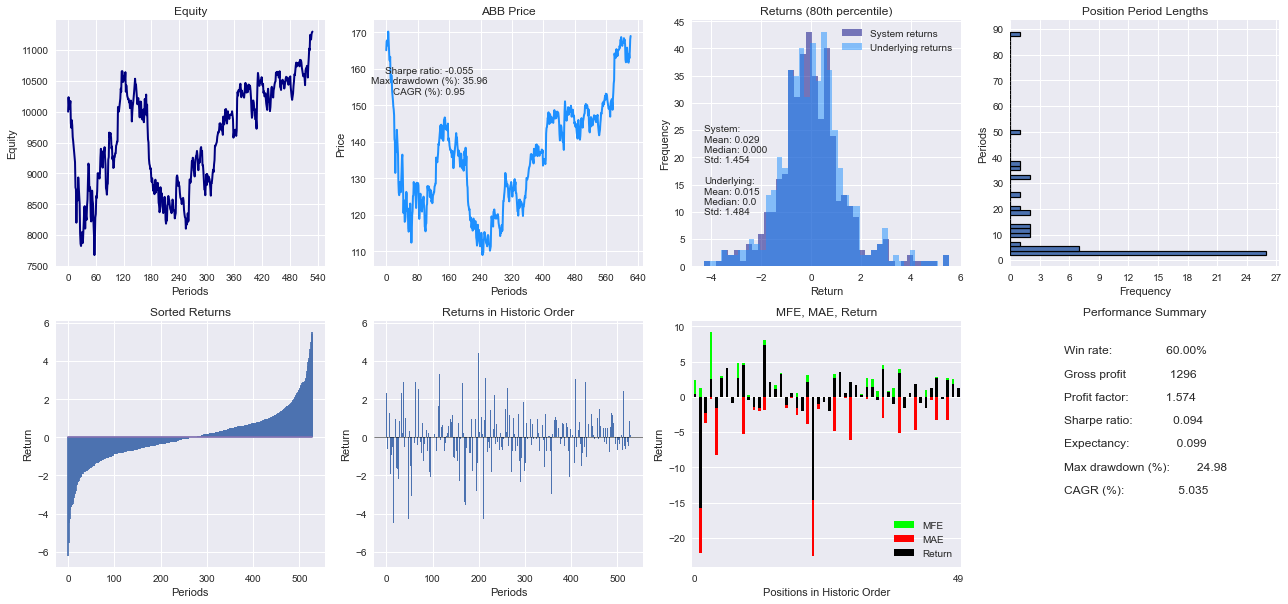


Entry index 17: 130.500, 2011-07-29 00:00:00+00:00
Unrealised P/L sequence: [1.3, -1.7, -5.5, -8.3, -14.5, -12.0, -17.2, -13.8, -11.0]
Market to market returns: [1.0, -2.28, -2.95, -2.24, -5.07, 2.16, -4.39, 3.0, 2.4]
Unrealised return sequence: [1.0, -1.3, -4.21, -6.36, -11.11, -9.2, -13.18, -10.57, -8.43]
Exit index 25: 119.500, 2011-08-10 00:00:00+00:00
Realised return: -8.43

Entry index 32: 110.000, 2011-08-19 00:00:00+00:00
Unrealised P/L sequence: [-1.0, 0.0, 5.0, 8.5, 7.5, 7.1]
Market to market returns: [-0.91, 0.92, 4.55, 3.04, -0.84, -0.34]
Unrealised return sequence: [-0.91, 0.0, 4.55, 7.73, 6.82, 6.45]
Exit index 37: 117.100, 2011-08-26 00:00:00+00:00
Realised return: 6.45

Entry index 47: 118.000, 2011-09-09 00:00:00+00:00
Unrealised P/L sequence: [-3.0, -4.3, -4.2, -2.2, -0.7, 0.3]
Market to market returns: [-2.54, -1.13, 0.09, 1.76, 1.3, 0.85]
Unrealised return sequence: [-2.54, -3.64, -3.56, -1.86, -0.59, 0.25]
Exit index 52: 118.300, 2011-09-16 00:00:00+00:00
Realised

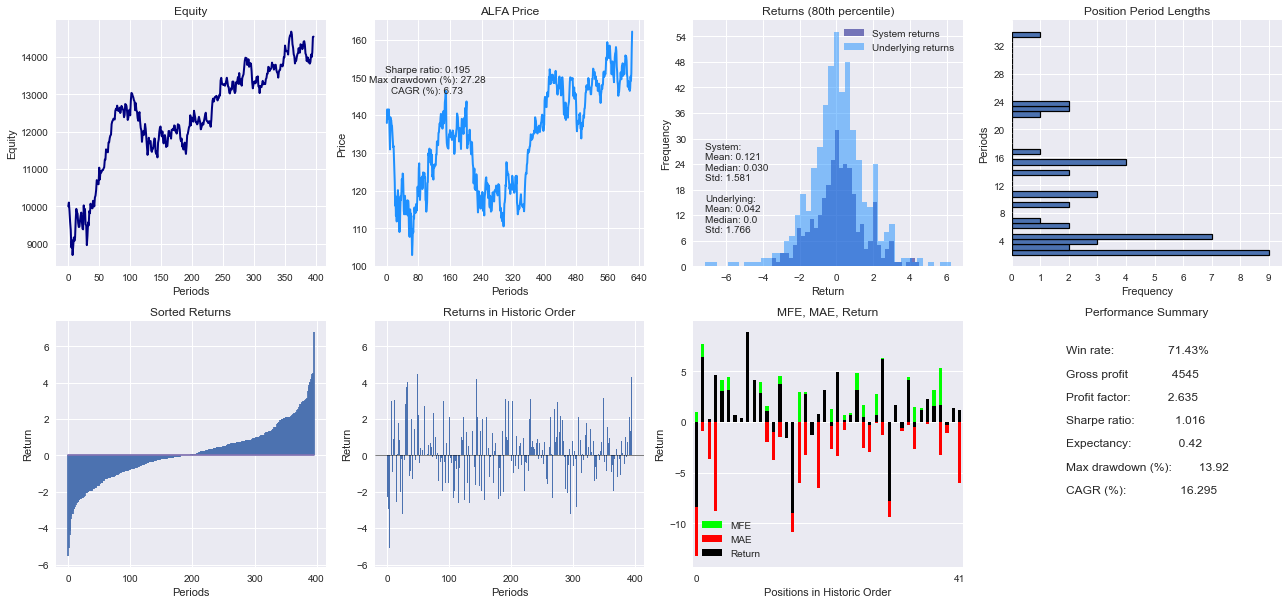


Entry index 4: 53.200, 2011-07-13 00:00:00+00:00
Unrealised P/L sequence: [1.53, 0.57, -0.67, -1.8, -1.63, -1.3, -0.6, -0.33, -0.77]
Market to market returns: [2.88, -1.77, -2.29, -2.16, 0.32, 0.65, 1.35, 0.51, -0.82]
Unrealised return sequence: [2.88, 1.07, -1.25, -3.38, -3.07, -2.44, -1.13, -0.63, -1.44]
Exit index 12: 52.433, 2011-07-25 00:00:00+00:00
Realised return: -1.44

Entry index 13: 52.767, 2011-07-26 00:00:00+00:00
Unrealised P/L sequence: [-0.23, 0.47, -0.67]
Market to market returns: [-0.44, 1.33, -2.13]
Unrealised return sequence: [-0.44, 0.88, -1.26]
Exit index 15: 52.100, 2011-07-28 00:00:00+00:00
Realised return: -1.26

Entry index 18: 52.533, 2011-08-02 00:00:00+00:00
Unrealised P/L sequence: [-2.63, -4.03, -6.53, -3.87, -6.5, -4.9, -3.87]
Market to market returns: [-5.01, -2.81, -5.15, 5.8, -5.41, 3.48, 2.17]
Unrealised return sequence: [-5.01, -7.68, -12.44, -7.36, -12.37, -9.33, -7.36]
Exit index 24: 48.667, 2011-08-10 00:00:00+00:00
Realised return: -7.36

Entry

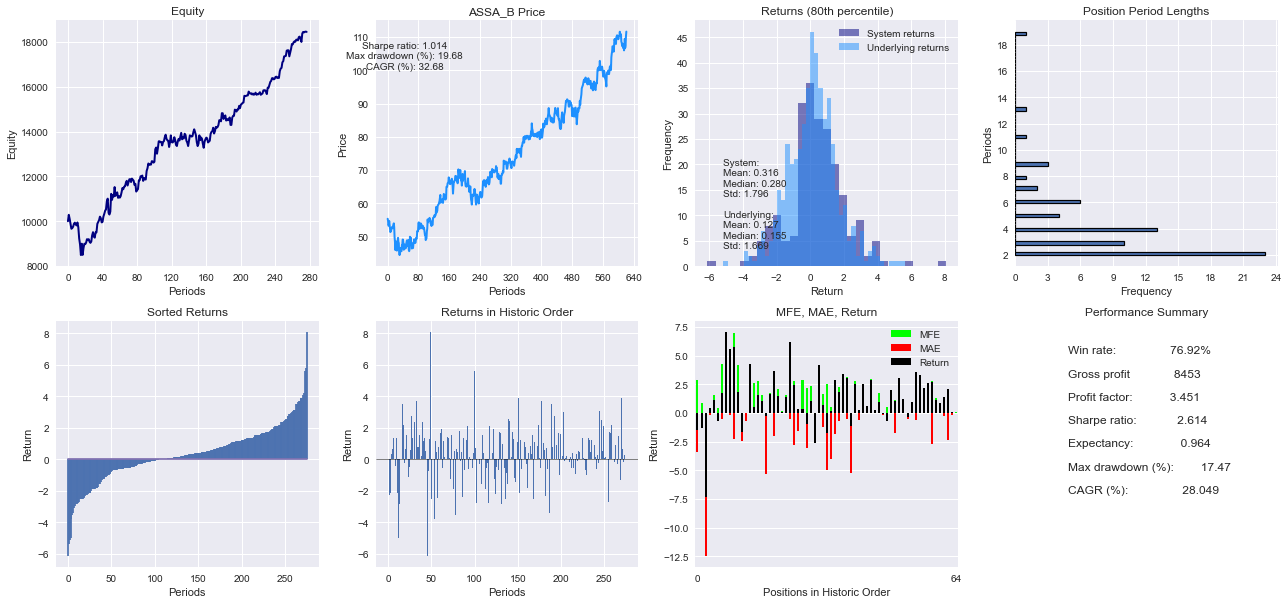


Entry index 9: 451.000, 2011-07-19 00:00:00+00:00
Unrealised P/L sequence: [-2.1, 2.4]
Market to market returns: [-0.47, 1.0]
Unrealised return sequence: [-0.47, 0.53]
Exit index 10: 453.400, 2011-07-20 00:00:00+00:00
Realised return: 0.53

Entry index 11: 451.900, 2011-07-21 00:00:00+00:00
Unrealised P/L sequence: [-23.8, -14.0, -15.4, -16.0]
Market to market returns: [-5.27, 2.29, -0.32, -0.14]
Unrealised return sequence: [-5.27, -3.1, -3.41, -3.54]
Exit index 14: 435.900, 2011-07-26 00:00:00+00:00
Realised return: -3.54

Entry index 15: 416.600, 2011-07-27 00:00:00+00:00
Unrealised P/L sequence: [1.3, 5.7, 1.9]
Market to market returns: [0.31, 1.05, -0.9]
Unrealised return sequence: [0.31, 1.37, 0.46]
Exit index 17: 418.500, 2011-07-29 00:00:00+00:00
Realised return: 0.46

Entry index 18: 425.400, 2011-08-01 00:00:00+00:00
Unrealised P/L sequence: [-13.2, -25.9, -36.8, -55.8, -67.5, -86.3, -69.0, -80.9, -80.1, -62.9, -67.3, -73.4, -80.3, -96.0, -107.9, -112.1, -106.4]
Market to mar

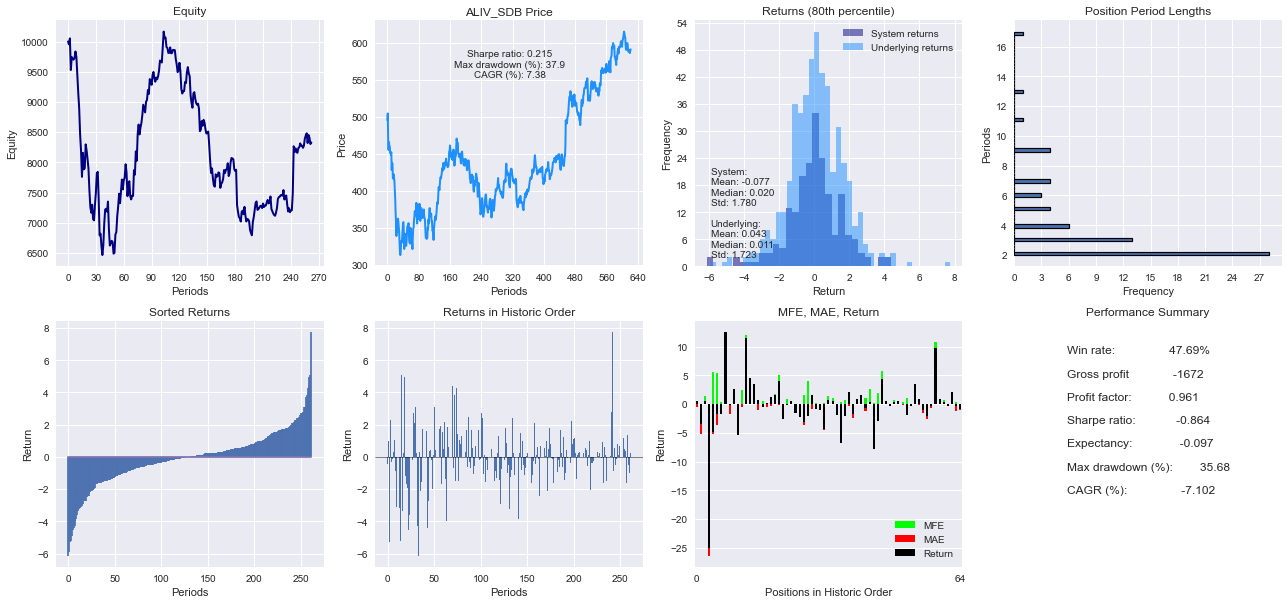


Entry index 4: 149.700, 2011-07-13 00:00:00+00:00
Unrealised P/L sequence: [1.4, -1.4, -2.9, -5.1, -19.7]
Market to market returns: [0.94, -1.85, -1.01, -1.5, -10.1]
Unrealised return sequence: [0.94, -0.94, -1.94, -3.41, -13.16]
Exit index 8: 130.000, 2011-07-19 00:00:00+00:00
Realised return: -13.16

Entry index 9: 123.900, 2011-07-20 00:00:00+00:00
Unrealised P/L sequence: [0.4, 0.1, -1.4, -0.1, -1.8, -2.8, -3.9, -5.0, -7.8, -11.3, -9.7, -13.6, -17.7]
Market to market returns: [0.32, -0.24, -1.21, 1.06, -1.37, -0.82, -0.91, -0.92, -2.35, -3.01, 1.42, -3.42, -3.72]
Unrealised return sequence: [0.32, 0.08, -1.13, -0.08, -1.45, -2.26, -3.15, -4.04, -6.3, -9.12, -7.83, -10.98, -14.29]
Exit index 21: 106.200, 2011-08-05 00:00:00+00:00
Realised return: -14.29

Entry index 31: 102.000, 2011-08-19 00:00:00+00:00
Unrealised P/L sequence: [-1.0, 0.6, 0.6, 2.0, -0.9, -1.6, 1.3, 0.5, 4.5, 3.7, 1.2, -3.7, -5.4, 0.1, -0.3, -5.1, -6.7, -4.7, -2.0, 2.7, 3.5]
Market to market returns: [-0.98, 1.58,

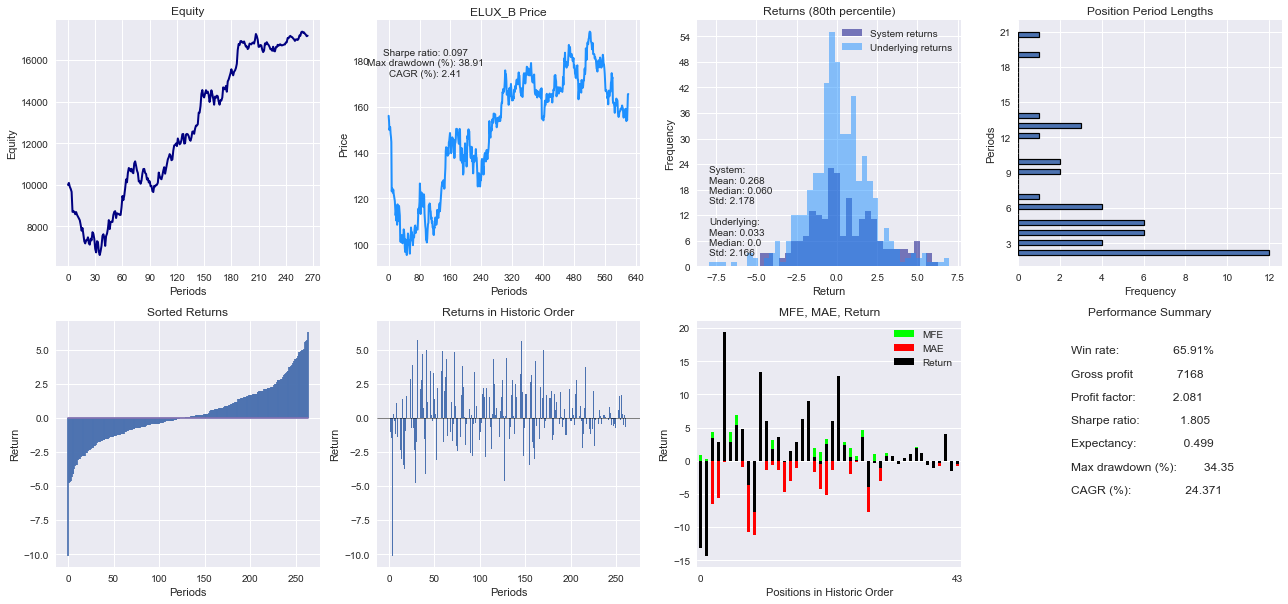


Entry index 22: 82.700, 2011-08-08 00:00:00+00:00
Unrealised P/L sequence: [-1.75, 3.05, -1.9, 3.45, 4.6, 5.15, 2.7, 2.55, -4.9, -6.9, -6.75, -6.25, -4.85, -4.55, -4.6]
Market to market returns: [-2.12, 5.93, -5.77, 6.62, 1.33, 0.63, -2.79, -0.18, -8.74, -2.57, 0.2, 0.66, 1.83, 0.39, -0.06]
Unrealised return sequence: [-2.12, 3.69, -2.3, 4.17, 5.56, 6.23, 3.26, 3.08, -5.93, -8.34, -8.16, -7.56, -5.86, -5.5, -5.56]
Exit index 36: 78.100, 2011-08-26 00:00:00+00:00
Realised return: -5.56

Entry index 37: 79.950, 2011-08-29 00:00:00+00:00
Unrealised P/L sequence: [0.65, 2.95, 7.5, 7.75, 3.6, -2.65, -3.2, 0.95, 3.85, -1.15, -4.35, -2.3, -1.95, 2.45, 3.1, -1.45, 2.45, -0.2, -6.15, -8.95, -10.3, -3.8, -7.4, -5.45, -8.1, -9.35, -13.2, -9.25, -4.35, -1.75, 1.95, 2.05, 5.25, 1.4, 5.4, 3.8, 4.1, 4.95, 2.25, 6.3, 11.0, 11.4, 12.85, 19.45, 20.15, 13.25, 6.5, 11.65, 14.05, 14.85, 12.0, 12.65, 10.75, 11.0, 15.0, 15.25, 13.25, 13.5, 10.6, 11.05, 4.9, 3.9, 1.6, 3.2, 4.35, 9.05, 8.6, 17.3, 18.1, 19.65,

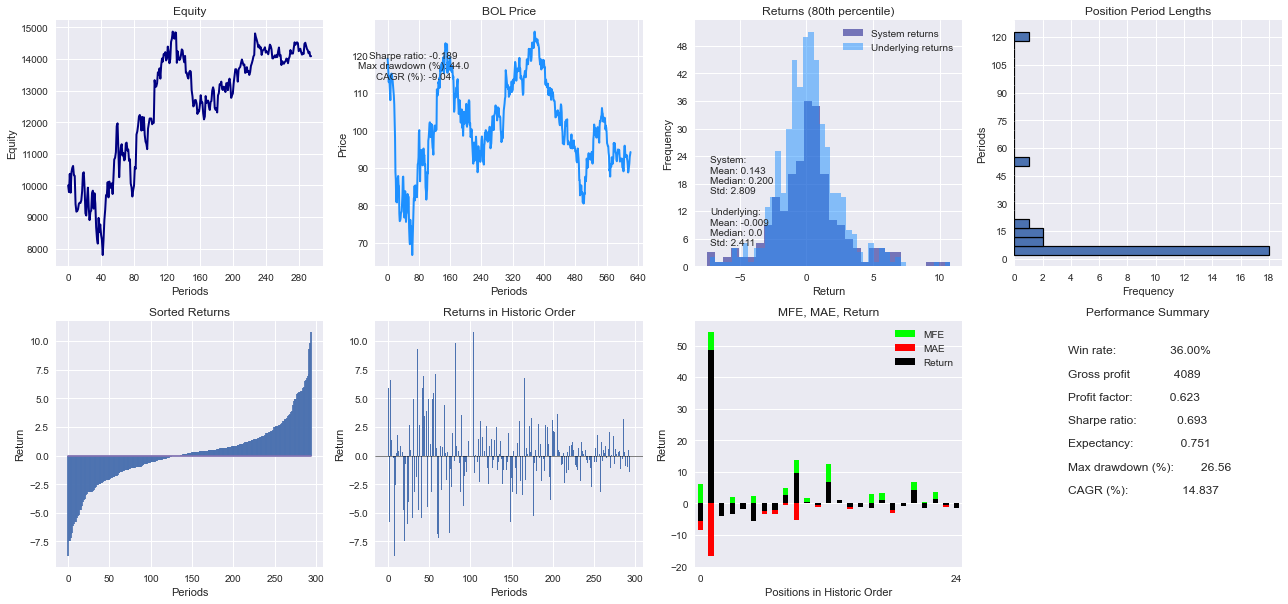


Entry index 4: 108.009, 2011-07-12 00:00:00+00:00
Unrealised P/L sequence: [0.9, 4.72, 2.69, -0.22, -8.76, -5.01, -3.22, -3.37, -2.47]
Market to market returns: [0.83, 3.51, -1.79, -2.64, -7.92, 3.77, 1.74, -0.14, 0.86]
Unrealised return sequence: [0.83, 4.37, 2.49, -0.21, -8.11, -4.64, -2.98, -3.12, -2.29]
Exit index 12: 105.539, 2011-07-22 00:00:00+00:00
Realised return: -2.29

Entry index 15: 101.123, 2011-07-27 00:00:00+00:00
Unrealised P/L sequence: [0.15, -1.5, -1.65, -5.99, -8.91, -12.05, -15.42, -14.45, -18.34, -12.95, -15.42, -13.25]
Market to market returns: [0.15, -1.63, -0.15, -4.36, -3.07, -3.41, -3.78, 1.14, -4.49, 6.51, -2.8, 2.53]
Unrealised return sequence: [0.15, -1.48, -1.63, -5.92, -8.81, -11.92, -15.25, -14.29, -18.13, -12.81, -15.25, -13.1]
Exit index 26: 87.874, 2011-08-11 00:00:00+00:00
Realised return: -13.10

Entry index 32: 84.506, 2011-08-19 00:00:00+00:00
Unrealised P/L sequence: [0.15, 2.32, 3.89, 4.94, 6.44]
Market to market returns: [0.18, 2.56, 1.81, 1

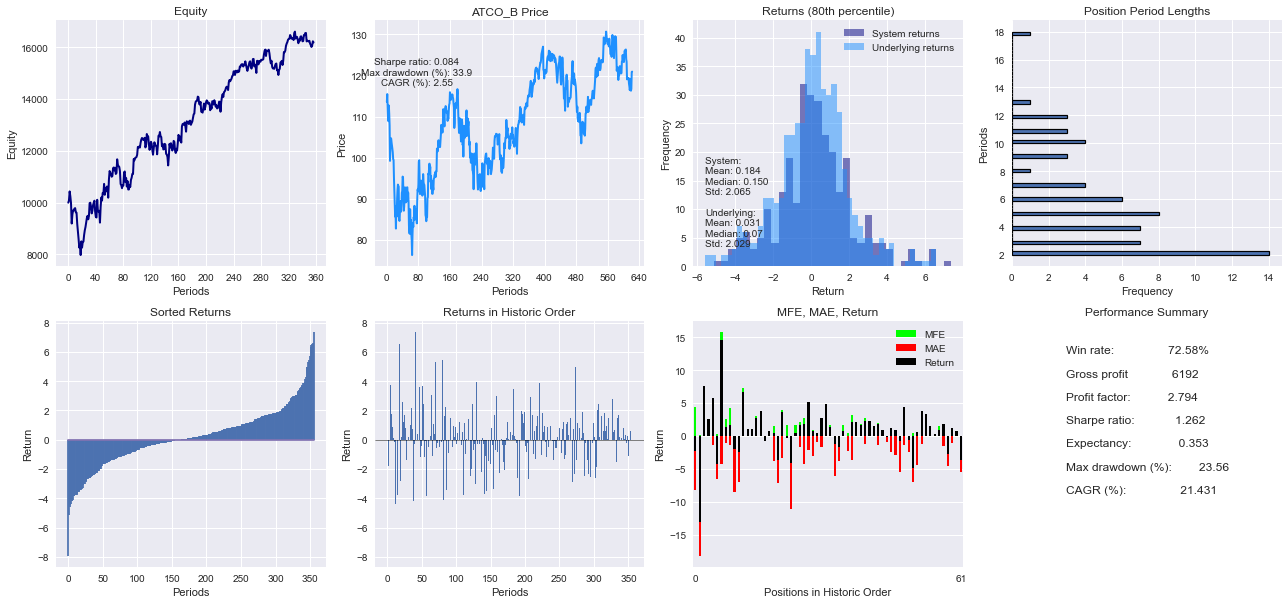


Entry index 4: 320.600, 2011-07-11 00:00:00+00:00
Unrealised P/L sequence: [3.4, 3.9, 0.9, -0.4]
Market to market returns: [1.06, 0.15, -0.92, -0.4]
Unrealised return sequence: [1.06, 1.22, 0.28, -0.12]
Exit index 7: 320.200, 2011-07-14 00:00:00+00:00
Realised return: -0.12

Entry index 8: 320.900, 2011-07-15 00:00:00+00:00
Unrealised P/L sequence: [0.8, -1.6, -1.7]
Market to market returns: [0.25, -0.75, -0.03]
Unrealised return sequence: [0.25, -0.5, -0.53]
Exit index 10: 319.200, 2011-07-19 00:00:00+00:00
Realised return: -0.53

Entry index 13: 319.900, 2011-07-22 00:00:00+00:00
Unrealised P/L sequence: [-4.7, -4.4, -7.3, -8.1, -8.3, -10.9, -9.1]
Market to market returns: [-1.47, 0.1, -0.92, -0.26, -0.06, -0.83, 0.58]
Unrealised return sequence: [-1.47, -1.38, -2.28, -2.53, -2.59, -3.41, -2.84]
Exit index 19: 310.800, 2011-08-01 00:00:00+00:00
Realised return: -2.84

Entry index 22: 292.900, 2011-08-04 00:00:00+00:00
Unrealised P/L sequence: [-5.6, -8.2, -17.0, -17.5, -23.6, -9.4, 

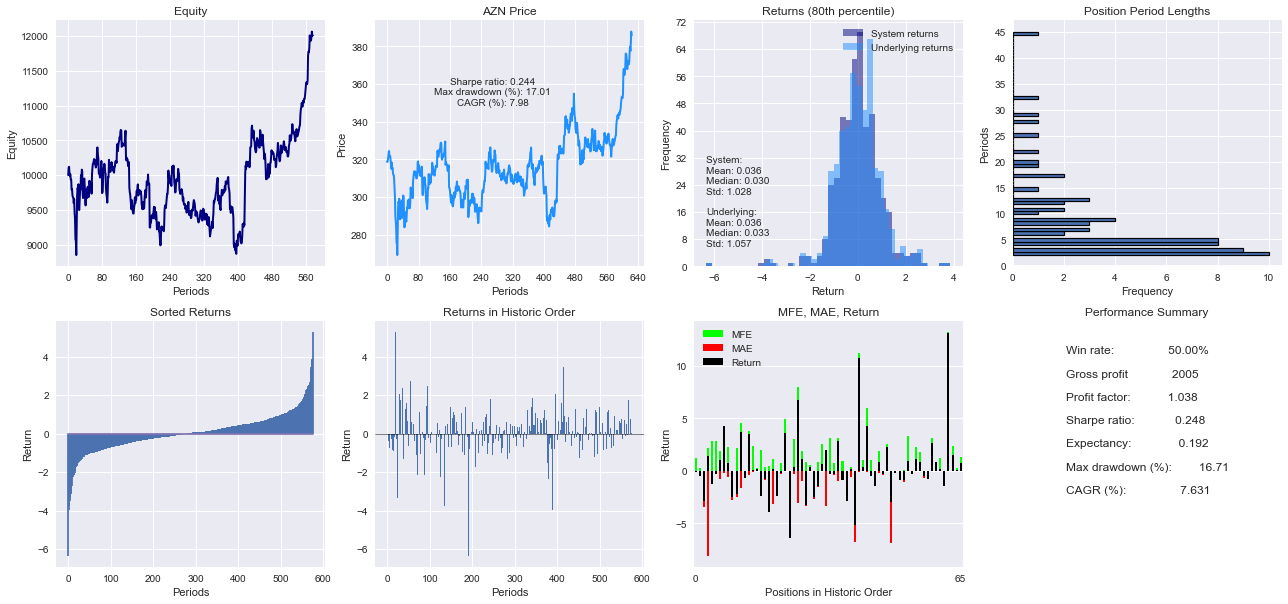


Entry index 7: 20.971, 2011-07-15 00:00:00+00:00
Unrealised P/L sequence: [-0.41, -1.76, -0.9, -0.96, -1.46, -1.49, -1.83, -2.24, -1.94, -2.4, -2.63, -2.84, -3.44, -3.11, -3.0]
Market to market returns: [-1.98, -6.53, 4.46, -0.28, -2.5, -0.15, -1.76, -2.16, 1.6, -2.4, -1.23, -1.17, -3.31, 1.87, 0.64]
Unrealised return sequence: [-1.98, -8.38, -4.29, -4.56, -6.95, -7.08, -8.72, -10.69, -9.26, -11.44, -12.53, -13.56, -16.42, -14.85, -14.31]
Exit index 21: 17.971, 2011-08-04 00:00:00+00:00
Realised return: -14.31

Entry index 22: 14.586, 2011-08-05 00:00:00+00:00
Unrealised P/L sequence: [0.57, -0.29, 0.91, 0.41, 1.01, 1.7, 1.67, 1.36, 1.07, -0.45, -1.06, -1.15, -1.06, -0.86, -0.63, -0.66]
Market to market returns: [3.92, -5.66, 8.39, -3.23, 4.0, 4.4, -0.18, -1.93, -1.79, -9.72, -4.35, -0.63, 0.64, 1.53, 1.66, -0.2]
Unrealised return sequence: [3.92, -1.96, 6.27, 2.84, 6.95, 11.66, 11.46, 9.3, 7.35, -3.09, -7.3, -7.88, -7.3, -5.88, -4.31, -4.51]
Exit index 37: 13.929, 2011-08-26 00:00:00

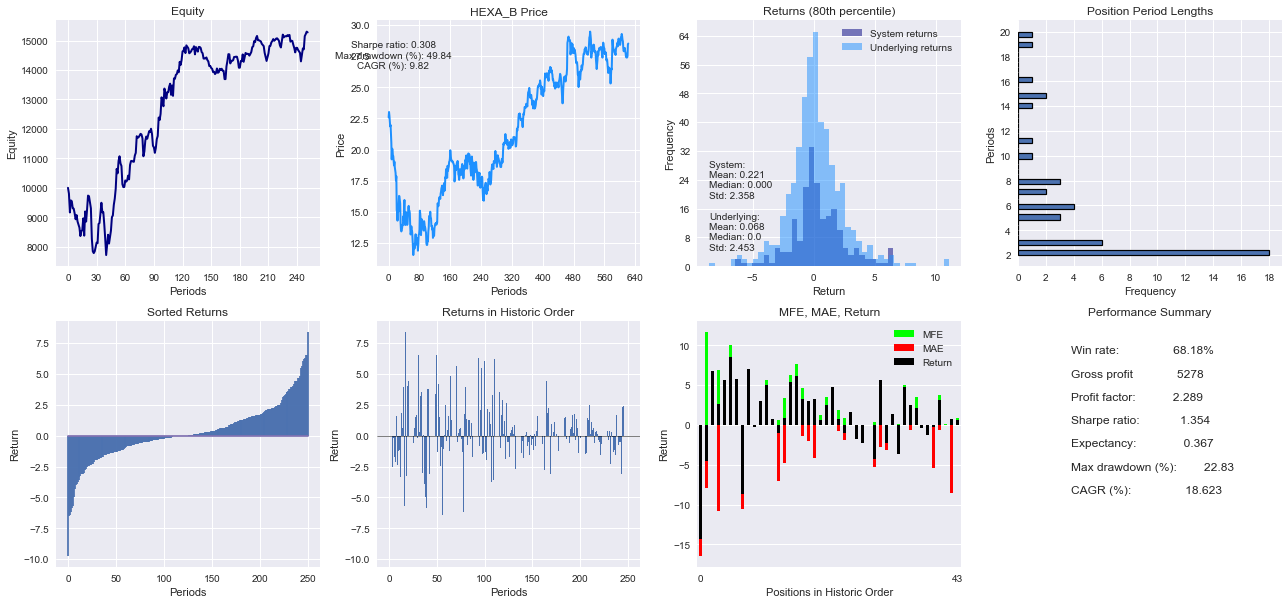


Entry index 7: 90.000, 2011-07-18 00:00:00+00:00
Unrealised P/L sequence: [-0.95, 1.55, 1.9, -7.0, -6.55, -6.6, -7.8, -9.1, -9.6, -10.7, -12.1, -12.05, -15.4, -17.9, -15.7, -20.15, -18.3, -19.3, -17.3, -17.3, -17.35, -19.3, -19.8, -24.05, -24.05, -24.6, -23.1, -21.7, -22.45, -21.85, -19.9, -20.25, -18.45, -17.45, -18.6, -23.1, -22.15, -19.5, -19.35, -20.1]
Market to market returns: [-1.06, 2.81, 0.38, -9.68, 0.54, -0.06, -1.44, -1.58, -0.62, -1.37, -1.77, 0.06, -4.3, -3.35, 3.05, -5.99, 2.65, -1.39, 2.83, 0.0, -0.07, -2.68, -0.71, -6.05, 0.0, -0.83, 2.29, 2.09, -1.1, 0.89, 2.86, -0.5, 2.58, 1.4, -1.59, -6.3, 1.42, 3.91, 0.21, -1.06]
Unrealised return sequence: [-1.06, 1.72, 2.11, -7.78, -7.28, -7.33, -8.67, -10.11, -10.67, -11.89, -13.44, -13.39, -17.11, -19.89, -17.44, -22.39, -20.33, -21.44, -19.22, -19.22, -19.28, -21.44, -22.0, -26.72, -26.72, -27.33, -25.67, -24.11, -24.94, -24.28, -22.11, -22.5, -20.5, -19.39, -20.67, -25.67, -24.61, -21.67, -21.5, -22.33]
Exit index 46: 69.900,

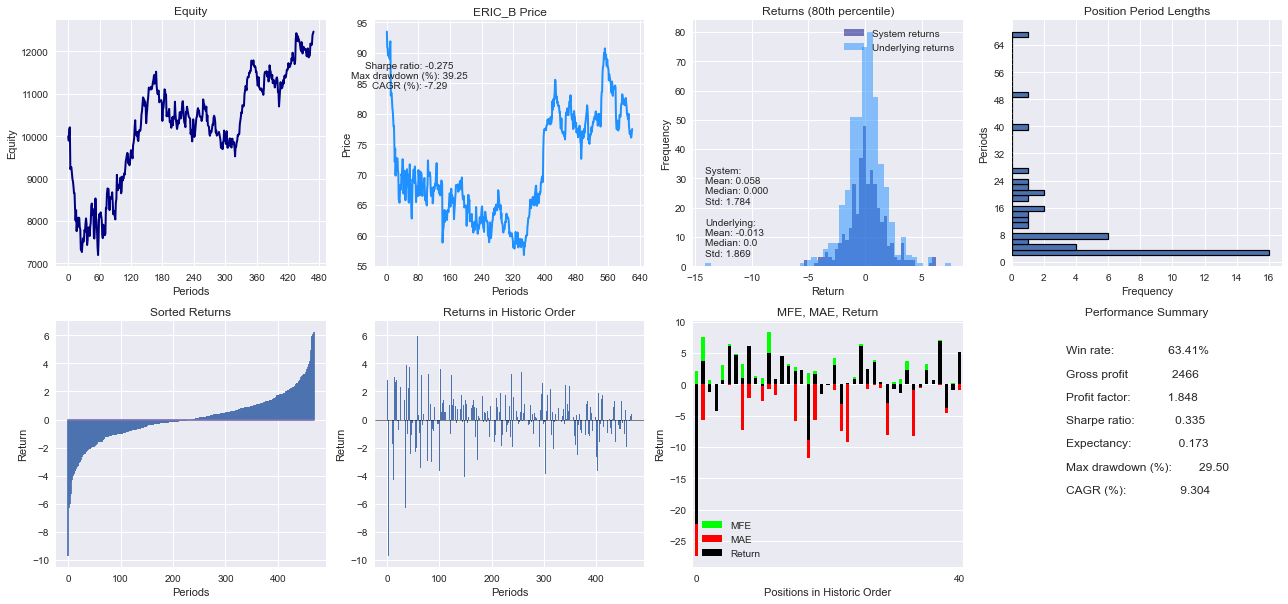


Entry index 8: 35.100, 2011-07-18 00:00:00+00:00
Unrealised P/L sequence: [-0.4, -0.1, 0.55, 0.55, 0.38, 0.17, 0.0, -0.3, -0.5, -0.83, -1.7, -2.7, -3.55, -4.6, -4.65, -5.7, -5.25, -6.18, -4.7, -3.75, -3.38, -3.38]
Market to market returns: [-1.14, 0.86, 1.86, 0.0, -0.49, -0.56, -0.5, -0.85, -0.57, -0.94, -2.55, -2.99, -2.62, -3.33, -0.16, -3.45, 1.53, -3.1, 5.1, 3.13, 1.2, 0.0]
Unrealised return sequence: [-1.14, -0.28, 1.57, 1.57, 1.07, 0.5, 0.0, -0.85, -1.42, -2.35, -4.84, -7.69, -10.11, -13.11, -13.25, -16.24, -14.96, -17.59, -13.39, -10.68, -9.62, -9.62]
Exit index 29: 31.725, 2011-08-16 00:00:00+00:00
Realised return: -9.62

Entry index 30: 31.075, 2011-08-17 00:00:00+00:00
Unrealised P/L sequence: [-0.12, -1.8, -2.05, -1.68, -1.47, -0.6, -0.25]
Market to market returns: [-0.4, -5.41, -0.85, 1.29, 0.68, 2.96, 1.15]
Unrealised return sequence: [-0.4, -5.79, -6.6, -5.39, -4.75, -1.93, -0.8]
Exit index 36: 30.825, 2011-08-25 00:00:00+00:00
Realised return: -0.80

Entry index 37: 29.

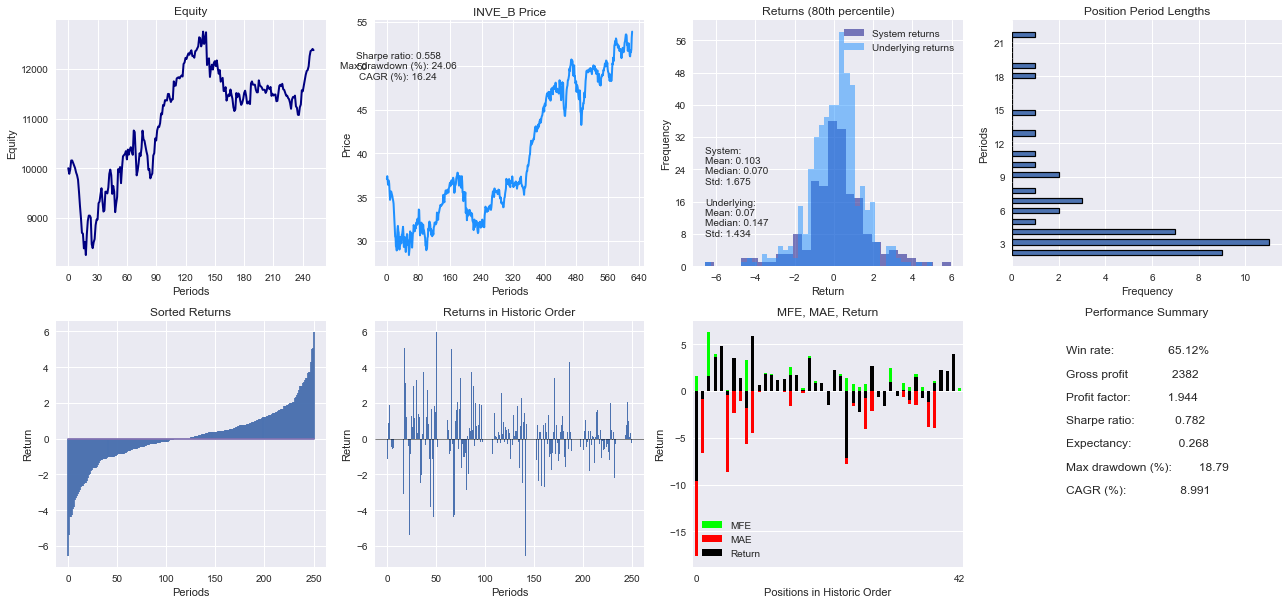


Entry index 4: 124.022, 2011-07-12 00:00:00+00:00
Unrealised P/L sequence: [1.67, 4.64, 2.13, -0.15, -10.12, -6.09, -4.95, -4.57]
Market to market returns: [1.35, 2.36, -1.95, -1.81, -8.05, 3.54, 0.97, 0.32]
Unrealised return sequence: [1.35, 3.74, 1.72, -0.12, -8.16, -4.91, -3.99, -3.68]
Exit index 11: 119.457, 2011-07-21 00:00:00+00:00
Realised return: -3.68

Entry index 15: 115.196, 2011-07-27 00:00:00+00:00
Unrealised P/L sequence: [-0.3, -1.37, -1.75, -6.32, -9.82, -13.01, -16.82, -16.43, -20.39, -15.52, -11.34]
Market to market returns: [-0.26, -0.93, -0.33, -4.02, -3.21, -3.03, -3.72, 0.39, -4.01, 5.14, 4.2]
Unrealised return sequence: [-0.26, -1.19, -1.52, -5.48, -8.52, -11.29, -14.6, -14.27, -17.7, -13.47, -9.84]
Exit index 25: 103.859, 2011-08-10 00:00:00+00:00
Realised return: -9.84

Entry index 33: 96.174, 2011-08-22 00:00:00+00:00
Unrealised P/L sequence: [3.12, 4.11, 5.1]
Market to market returns: [3.24, 1.0, 0.99]
Unrealised return sequence: [3.24, 4.27, 5.3]
Exit index

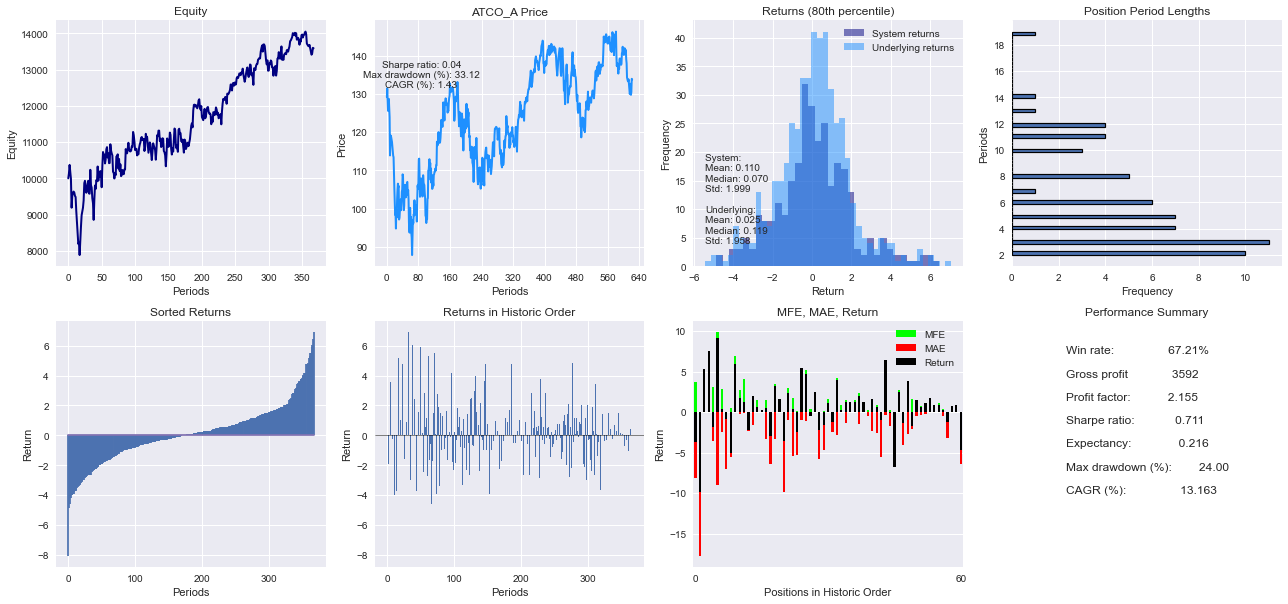


Entry index 18: 133.556, 2011-08-02 00:00:00+00:00
Unrealised P/L sequence: [-2.02, -7.37, -13.44, -12.71, -20.4, -15.54, -17.65, -13.84, -11.25, -9.63, -9.63, -8.18, -9.31]
Market to market returns: [-1.52, -4.06, -4.81, 0.61, -6.36, 4.29, -1.78, 3.28, 2.16, 1.32, 0.0, 1.18, -0.9]
Unrealised return sequence: [-1.52, -5.52, -10.06, -9.52, -15.27, -11.64, -13.21, -10.36, -8.42, -7.21, -7.21, -6.12, -6.97]
Exit index 30: 124.248, 2011-08-18 00:00:00+00:00
Realised return: -6.97

Entry index 31: 119.796, 2011-08-19 00:00:00+00:00
Unrealised P/L sequence: [0.16, 1.78, 3.16]
Market to market returns: [0.14, 1.35, 1.13]
Unrealised return sequence: [0.14, 1.49, 2.64]
Exit index 33: 122.953, 2011-08-23 00:00:00+00:00
Realised return: 2.64

Entry index 36: 123.924, 2011-08-26 00:00:00+00:00
Unrealised P/L sequence: [0.08, 1.62]
Market to market returns: [0.07, 1.24]
Unrealised return sequence: [0.07, 1.31]
Exit index 37: 125.543, 2011-08-29 00:00:00+00:00
Realised return: 1.31

Entry index 195

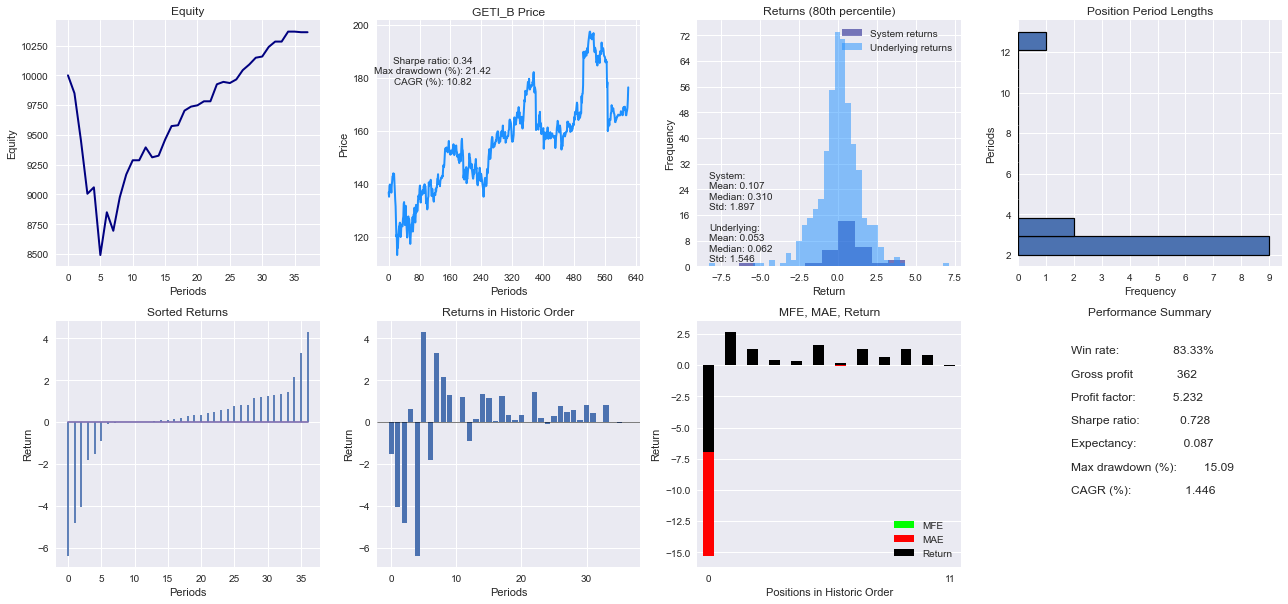


Entry index 4: 219.800, 2011-07-13 00:00:00+00:00
Unrealised P/L sequence: [-1.4, -4.4, -4.6, -5.6, -4.8, -3.5, -3.1]
Market to market returns: [-0.64, -1.37, -0.09, -0.46, 0.37, 0.6, 0.18]
Unrealised return sequence: [-0.64, -2.0, -2.09, -2.55, -2.18, -1.59, -1.41]
Exit index 10: 216.700, 2011-07-21 00:00:00+00:00
Realised return: -1.41

Entry index 14: 214.800, 2011-07-27 00:00:00+00:00
Unrealised P/L sequence: [1.4, 1.3, 0.3, -3.1, -10.1, -15.1, -22.2, -20.2, -24.3, -20.9, -22.0, -16.8, -12.9, -13.1, -12.8]
Market to market returns: [0.65, -0.05, -0.46, -1.58, -3.31, -2.44, -3.56, 1.04, -2.11, 1.78, -0.57, 2.7, 1.97, -0.1, 0.15]
Unrealised return sequence: [0.65, 0.61, 0.14, -1.44, -4.7, -7.03, -10.34, -9.4, -11.31, -9.73, -10.24, -7.82, -6.01, -6.1, -5.96]
Exit index 28: 202.000, 2011-08-16 00:00:00+00:00
Realised return: -5.96

Entry index 29: 203.100, 2011-08-17 00:00:00+00:00
Unrealised P/L sequence: [3.9, -8.6, -15.1, -11.2, -5.2, -6.9, -4.7]
Market to market returns: [1.92, -

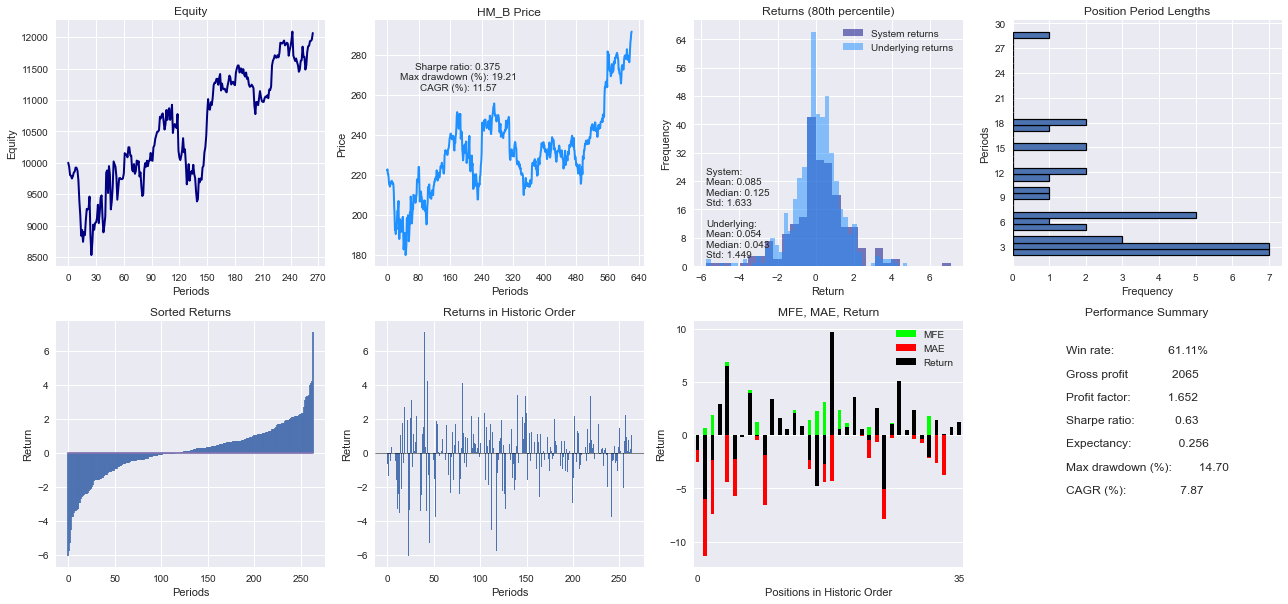


Entry index 4: 128.377, 2011-07-12 00:00:00+00:00
Unrealised P/L sequence: [2.66, 3.04, 2.28, 1.42]
Market to market returns: [2.07, 0.29, -0.58, -0.65]
Unrealised return sequence: [2.07, 2.37, 1.78, 1.11]
Exit index 7: 129.801, 2011-07-15 00:00:00+00:00
Realised return: 1.11

Entry index 25: 118.692, 2011-08-10 00:00:00+00:00
Unrealised P/L sequence: [-5.03, -3.8]
Market to market returns: [-4.24, 1.09]
Unrealised return sequence: [-4.24, -3.2]
Exit index 26: 114.894, 2011-08-11 00:00:00+00:00
Realised return: -3.20

Entry index 157: 134.644, 2012-02-15 00:00:00+00:00
Unrealised P/L sequence: [0.95, 1.61]
Market to market returns: [0.71, 0.49]
Unrealised return sequence: [0.71, 1.2]
Exit index 158: 136.258, 2012-02-16 00:00:00+00:00
Realised return: 1.20

Entry index 159: 137.492, 2012-02-17 00:00:00+00:00
Unrealised P/L sequence: [-0.09, -0.09]
Market to market returns: [-0.07, 0.0]
Unrealised return sequence: [-0.07, -0.07]
Exit index 160: 137.397, 2012-02-20 00:00:00+00:00
Realise

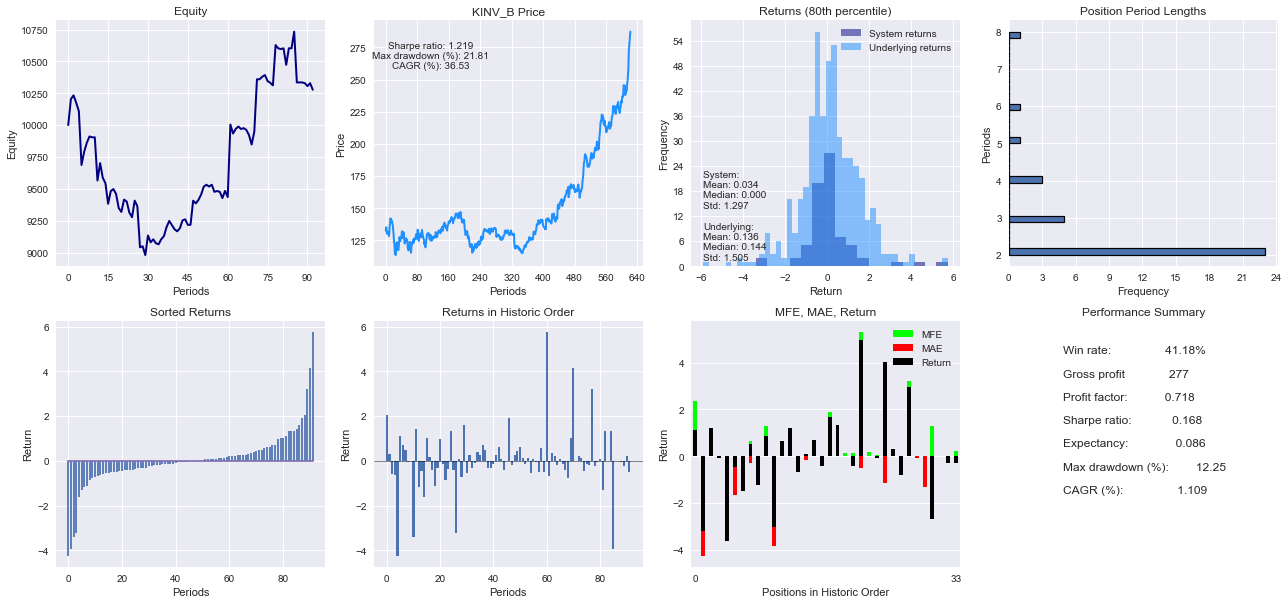


Entry index 6: 108.600, 2011-07-14 00:00:00+00:00
Unrealised P/L sequence: [-0.2, -1.6, -2.4]
Market to market returns: [-0.18, -1.29, -0.75]
Unrealised return sequence: [-0.18, -1.47, -2.21]
Exit index 8: 106.200, 2011-07-18 00:00:00+00:00
Realised return: -2.21

Entry index 9: 104.700, 2011-07-19 00:00:00+00:00
Unrealised P/L sequence: [2.5, 2.8, 2.3]
Market to market returns: [2.39, 0.28, -0.47]
Unrealised return sequence: [2.39, 2.67, 2.2]
Exit index 11: 107.000, 2011-07-21 00:00:00+00:00
Realised return: 2.20

Entry index 17: 101.900, 2011-07-29 00:00:00+00:00
Unrealised P/L sequence: [0.7, 2.2]
Market to market returns: [0.69, 1.46]
Unrealised return sequence: [0.69, 2.16]
Exit index 18: 104.100, 2011-08-01 00:00:00+00:00
Realised return: 2.16

Entry index 19: 99.000, 2011-08-02 00:00:00+00:00
Unrealised P/L sequence: [-2.9, -5.15, -9.05, -7.6, -11.65, -8.4, -12.1, -5.15, -5.05]
Market to market returns: [-2.93, -2.34, -4.16, 1.61, -4.43, 3.72, -4.08, 8.0, 0.11]
Unrealised retur

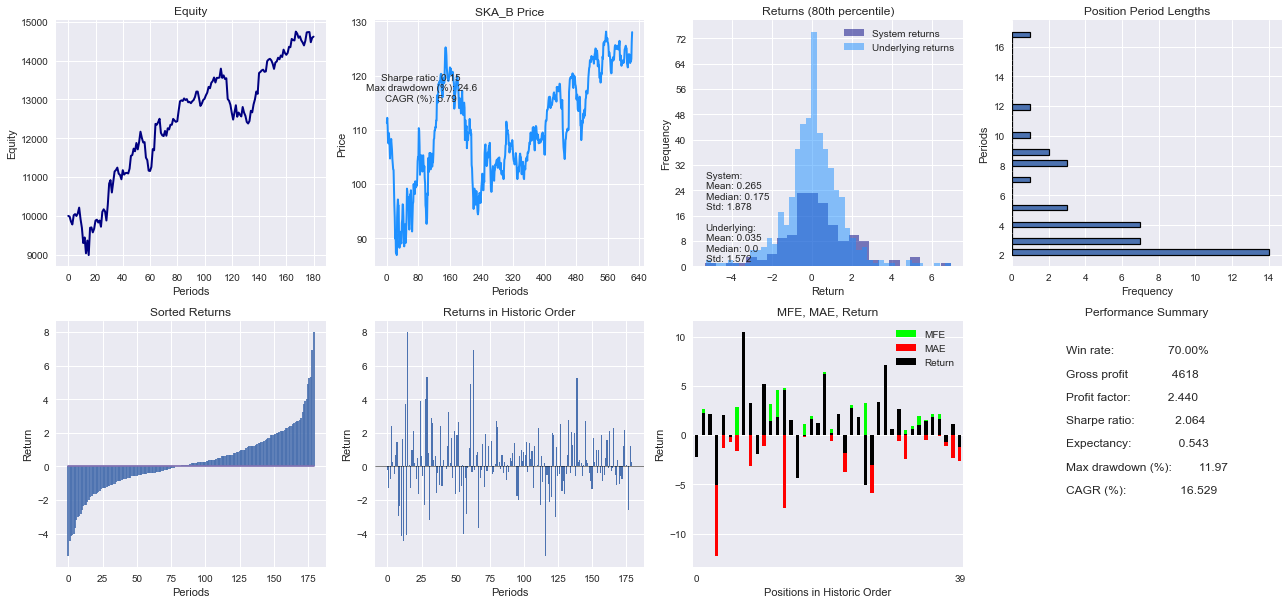


Entry index 10: 22.250, 2011-07-20 00:00:00+00:00
Unrealised P/L sequence: [0.46, 0.43]
Market to market returns: [2.07, -0.13]
Unrealised return sequence: [2.07, 1.93]
Exit index 11: 22.680, 2011-07-21 00:00:00+00:00
Realised return: 1.93

Entry index 13: 22.400, 2011-07-25 00:00:00+00:00
Unrealised P/L sequence: [0.35, 0.44]
Market to market returns: [1.56, 0.4]
Unrealised return sequence: [1.56, 1.96]
Exit index 14: 22.840, 2011-07-26 00:00:00+00:00
Realised return: 1.96

Entry index 21: 22.410, 2011-08-04 00:00:00+00:00
Unrealised P/L sequence: [-0.6, -0.41, -1.56, -0.34, 0.04]
Market to market returns: [-2.68, 0.87, -5.23, 5.85, 1.72]
Unrealised return sequence: [-2.68, -1.83, -6.96, -1.52, 0.18]
Exit index 25: 22.450, 2011-08-10 00:00:00+00:00
Realised return: 0.18

Entry index 28: 22.980, 2011-08-15 00:00:00+00:00
Unrealised P/L sequence: [0.24, 0.12]
Market to market returns: [1.04, -0.52]
Unrealised return sequence: [1.04, 0.52]
Exit index 29: 23.100, 2011-08-16 00:00:00+00:0

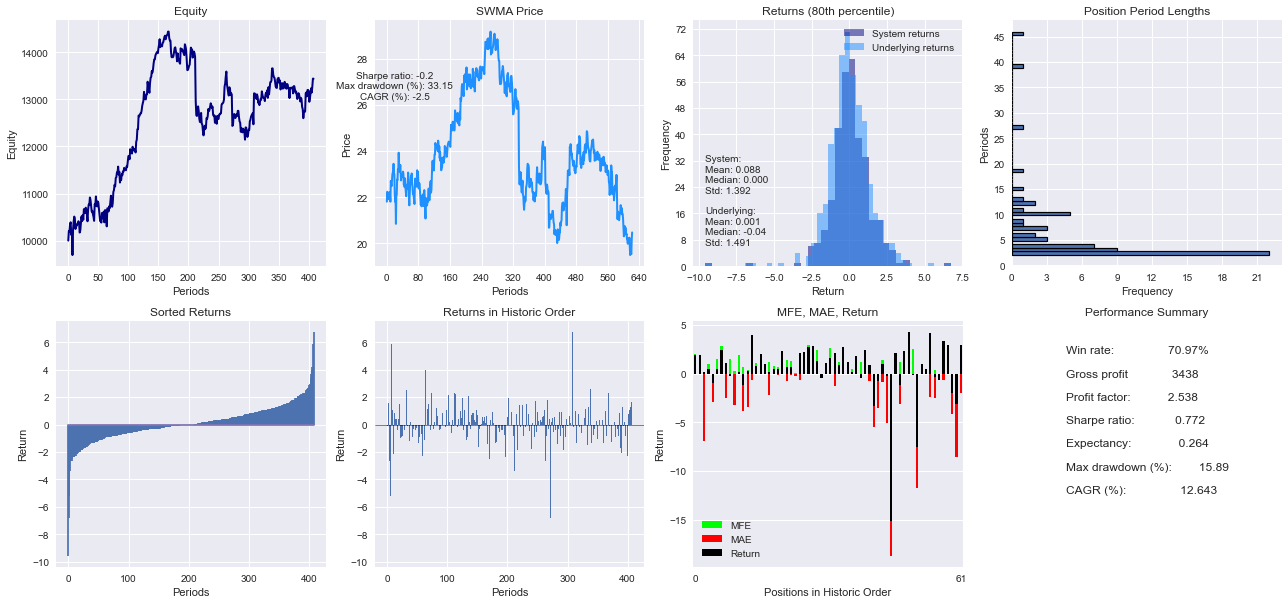


Entry index 4: 48.590, 2011-07-13 00:00:00+00:00
Unrealised P/L sequence: [0.62, -1.59, -2.51, -3.12, -2.21, -0.3, -0.18]
Market to market returns: [1.28, -4.49, -1.96, -1.32, 2.0, 4.12, 0.25]
Unrealised return sequence: [1.28, -3.27, -5.17, -6.42, -4.55, -0.62, -0.37]
Exit index 10: 48.410, 2011-07-21 00:00:00+00:00
Realised return: -0.37

Entry index 15: 47.020, 2011-07-28 00:00:00+00:00
Unrealised P/L sequence: [1.45, 1.09, -0.82, -2.73, -4.44, -6.72, -6.02, -8.3, -7.43, -9.9, -8.37, -7.35, -6.61, -6.73]
Market to market returns: [3.08, -0.74, -3.97, -4.13, -3.86, -5.35, 1.74, -5.56, 2.25, -6.24, 4.12, 2.64, 1.87, -0.3]
Unrealised return sequence: [3.08, 2.32, -1.74, -5.81, -9.44, -14.29, -12.8, -17.65, -15.8, -21.05, -17.8, -15.63, -14.06, -14.31]
Exit index 28: 40.290, 2011-08-16 00:00:00+00:00
Realised return: -14.31

Entry index 31: 36.000, 2011-08-19 00:00:00+00:00
Unrealised P/L sequence: [-0.83, -0.31, -0.5, 0.38, 0.44, 0.58]
Market to market returns: [-2.31, 1.48, -0.53, 2.

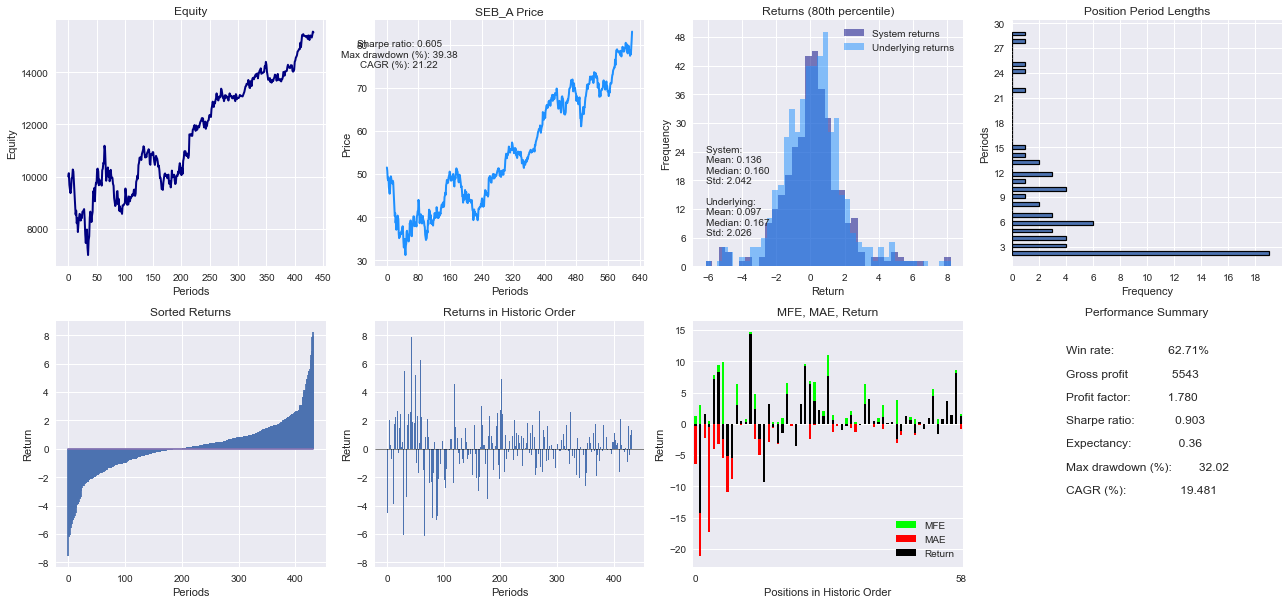


Entry index 5: 180.600, 2011-07-13 00:00:00+00:00
Unrealised P/L sequence: [6.0, 3.4]
Market to market returns: [3.32, -1.39]
Unrealised return sequence: [3.32, 1.88]
Exit index 6: 184.000, 2011-07-14 00:00:00+00:00
Realised return: 1.88

Entry index 7: 176.700, 2011-07-15 00:00:00+00:00
Unrealised P/L sequence: [-2.7, -6.0, -3.8, -1.4, -2.5, -4.0, -5.7]
Market to market returns: [-1.53, -1.9, 1.29, 1.39, -0.63, -0.86, -0.98]
Unrealised return sequence: [-1.53, -3.4, -2.15, -0.79, -1.41, -2.26, -3.23]
Exit index 13: 171.000, 2011-07-25 00:00:00+00:00
Realised return: -3.23

Entry index 14: 172.400, 2011-07-26 00:00:00+00:00
Unrealised P/L sequence: [-2.4, -5.3, -5.5, -6.1, -10.2, -17.1, -20.4, -24.4, -25.1, -34.0, -23.4, -30.6, -25.6, -23.4, -21.0, -21.9]
Market to market returns: [-1.39, -1.71, -0.12, -0.36, -2.47, -4.25, -2.12, -2.63, -0.47, -6.04, 7.66, -4.83, 3.53, 1.5, 1.61, -0.59]
Unrealised return sequence: [-1.39, -3.07, -3.19, -3.54, -5.92, -9.92, -11.83, -14.15, -14.56, -19.

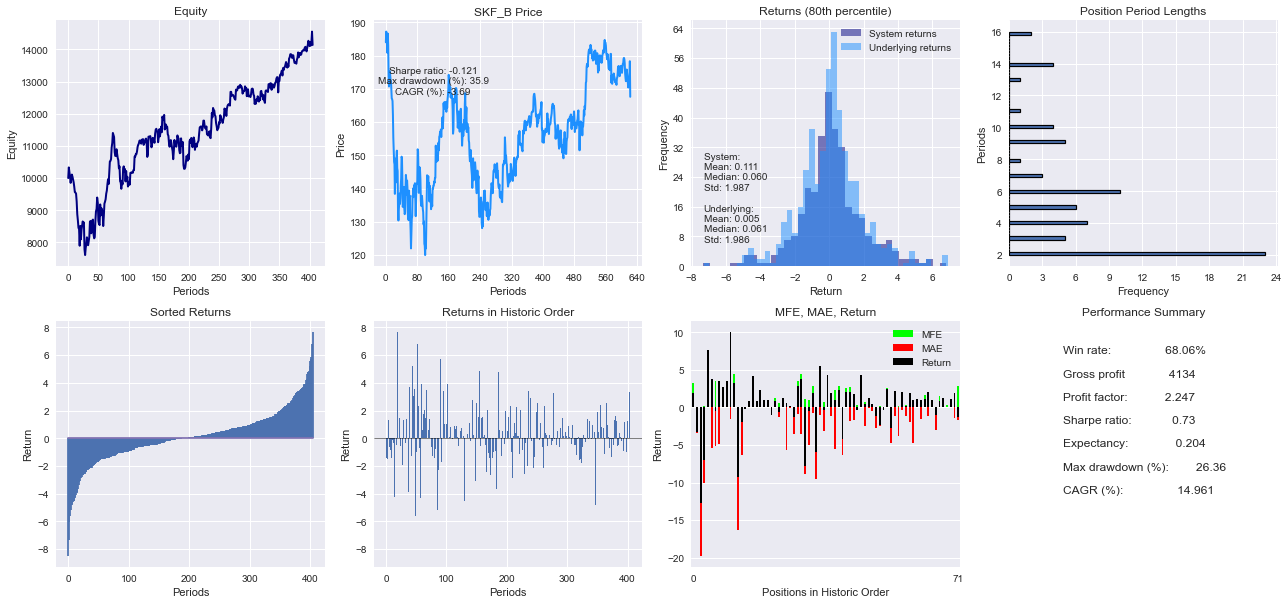


Entry index 4: 66.450, 2011-07-13 00:00:00+00:00
Unrealised P/L sequence: [-0.4, -1.75, -2.05, -3.6, -0.05, 1.75, 2.1]
Market to market returns: [-0.6, -2.04, -0.46, -2.41, 5.65, 2.71, 0.51]
Unrealised return sequence: [-0.6, -2.63, -3.09, -5.42, -0.08, 2.63, 3.16]
Exit index 10: 68.550, 2011-07-21 00:00:00+00:00
Realised return: 3.16

Entry index 13: 67.600, 2011-07-26 00:00:00+00:00
Unrealised P/L sequence: [-0.55, -0.75, -0.45, -0.5, -2.2, -3.6, -6.35, -8.25, -8.2, -10.65, -10.25, -10.85, -10.15, -8.85, -7.8, -8.7, -8.55, -12.9, -14.35, -13.6, -12.05, -11.4, -11.55, -12.05, -10.1, -10.0, -9.1, -8.5, -10.2, -13.55, -13.95, -12.15, -12.2, -15.65, -17.62, -16.05, -16.1, -13.1, -13.1, -15.3, -14.3, -14.8, -17.62, -17.0, -15.55, -10.4, -11.05]
Market to market returns: [-0.81, -0.3, 0.45, -0.07, -2.53, -2.14, -4.3, -3.1, 0.08, -4.12, 0.7, -1.05, 1.23, 2.26, 1.79, -1.51, 0.25, -7.37, -2.65, 1.41, 2.87, 1.17, -0.27, -0.89, 3.51, 0.17, 1.56, 1.03, -2.88, -5.84, -0.74, 3.36, -0.09, -6.23, -

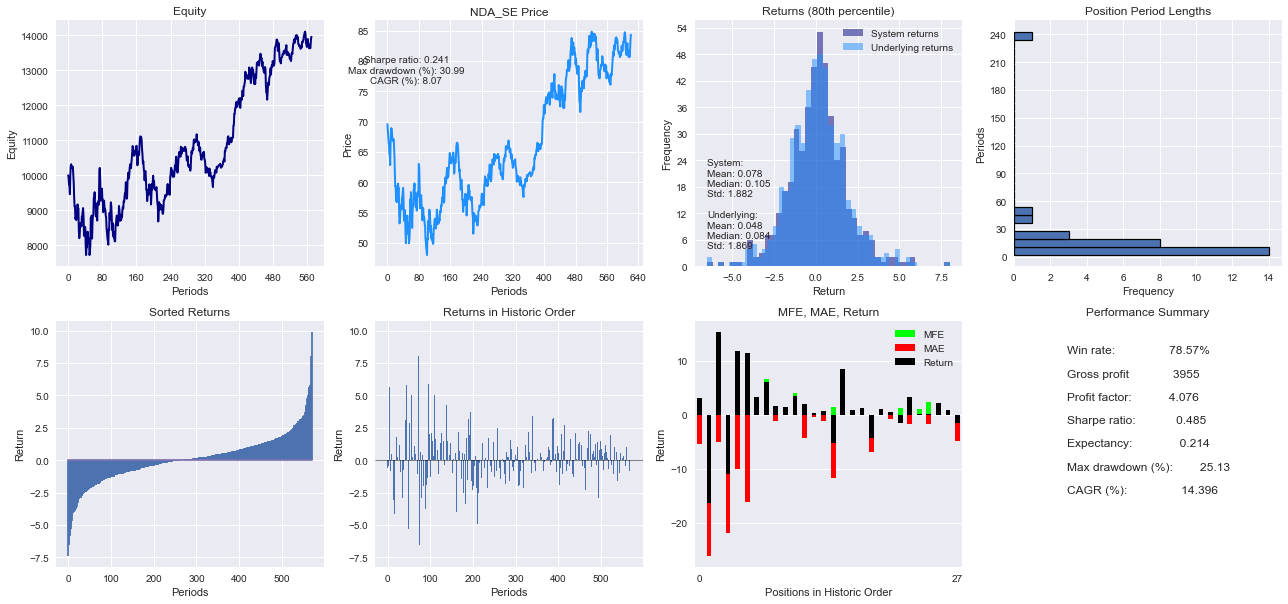


Entry index 4: 44.550, 2011-07-13 00:00:00+00:00
Unrealised P/L sequence: [0.22, -0.12, 0.33, -0.45, 0.62, 2.34, 2.99, 3.51, 3.33, 3.43, 3.37, 3.64, 3.66, 2.64, 2.1, 0.83, -0.87, -0.84, -2.36, -2.33, -3.11, -1.12, -1.05]
Market to market returns: [0.49, -0.76, 1.01, -1.74, 2.43, 3.81, 1.39, 1.09, -0.37, 0.21, -0.13, 0.56, 0.04, -2.12, -1.14, -2.72, -3.75, 0.07, -3.48, 0.07, -1.85, 4.8, 0.16]
Unrealised return sequence: [0.49, -0.27, 0.74, -1.01, 1.39, 5.25, 6.71, 7.88, 7.47, 7.7, 7.56, 8.17, 8.22, 5.93, 4.71, 1.86, -1.95, -1.89, -5.3, -5.23, -6.98, -2.51, -2.36]
Exit index 26: 43.500, 2011-08-12 00:00:00+00:00
Realised return: -2.36

Entry index 29: 43.930, 2011-08-17 00:00:00+00:00
Unrealised P/L sequence: [0.65, 0.17]
Market to market returns: [1.48, -1.08]
Unrealised return sequence: [1.48, 0.39]
Exit index 30: 44.100, 2011-08-18 00:00:00+00:00
Realised return: 0.39

Entry index 31: 42.560, 2011-08-19 00:00:00+00:00
Unrealised P/L sequence: [-0.67, 0.54, 2.05, 2.4]
Market to market

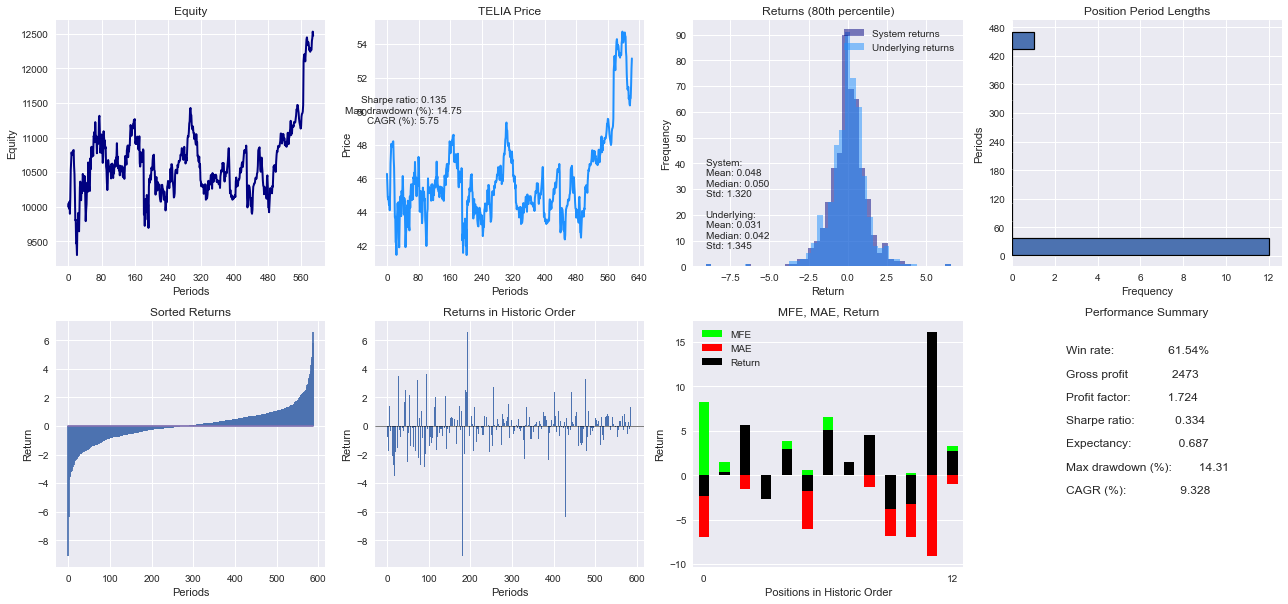


Entry index 4: 117.465, 2011-07-12 00:00:00+00:00
Unrealised P/L sequence: [2.79, 2.99, 4.05, 5.11, 5.78]
Market to market returns: [2.38, 0.16, 0.88, 0.87, 0.55]
Unrealised return sequence: [2.38, 2.54, 3.45, 4.35, 4.92]
Exit index 8: 123.247, 2011-07-18 00:00:00+00:00
Realised return: 4.92

Entry index 116: 119.971, 2011-12-15 00:00:00+00:00
Unrealised P/L sequence: [1.93, 2.31]
Market to market returns: [1.61, 0.32]
Unrealised return sequence: [1.61, 1.93]
Exit index 117: 122.284, 2011-12-16 00:00:00+00:00
Realised return: 1.93

Entry index 139: 123.247, 2012-01-20 00:00:00+00:00
Unrealised P/L sequence: [-3.08, -0.29, -0.48]
Market to market returns: [-2.5, 2.33, -0.16]
Unrealised return sequence: [-2.5, -0.23, -0.39]
Exit index 141: 122.765, 2012-01-24 00:00:00+00:00
Realised return: -0.39

Entry index 146: 125.174, 2012-01-31 00:00:00+00:00
Unrealised P/L sequence: [-0.1, 0.48]
Market to market returns: [-0.08, 0.46]
Unrealised return sequence: [-0.08, 0.38]
Exit index 147: 125.

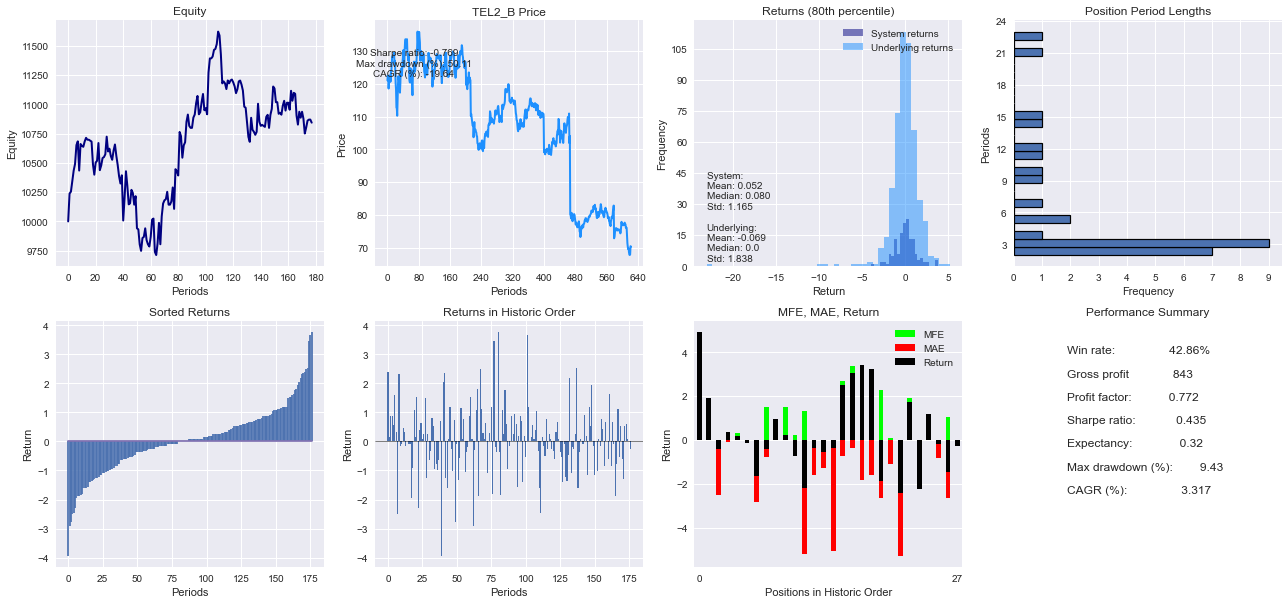


Entry index 9: 100.900, 2011-07-19 00:00:00+00:00
Unrealised P/L sequence: [2.7, 2.9]
Market to market returns: [2.68, 0.19]
Unrealised return sequence: [2.68, 2.87]
Exit index 10: 103.800, 2011-07-20 00:00:00+00:00
Realised return: 2.87

Entry index 20: 90.700, 2011-08-03 00:00:00+00:00
Unrealised P/L sequence: [-2.15, -9.25, -8.85, -14.1, -8.85, -14.15, -11.95]
Market to market returns: [-2.37, -8.02, 0.49, -6.41, 6.85, -6.48, 2.87]
Unrealised return sequence: [-2.37, -10.2, -9.76, -15.55, -9.76, -15.6, -13.18]
Exit index 26: 78.750, 2011-08-11 00:00:00+00:00
Realised return: -13.18

Entry index 32: 73.400, 2011-08-19 00:00:00+00:00
Unrealised P/L sequence: [-1.8, -2.25, -1.75, 0.1, -1.95, -0.85, 0.5, 1.5]
Market to market returns: [-2.45, -0.63, 0.7, 2.58, -2.79, 1.54, 1.86, 1.35]
Unrealised return sequence: [-2.45, -3.07, -2.38, 0.14, -2.66, -1.16, 0.68, 2.04]
Exit index 39: 74.900, 2011-08-30 00:00:00+00:00
Realised return: 2.04

Entry index 44: 70.850, 2011-09-06 00:00:00+00:00


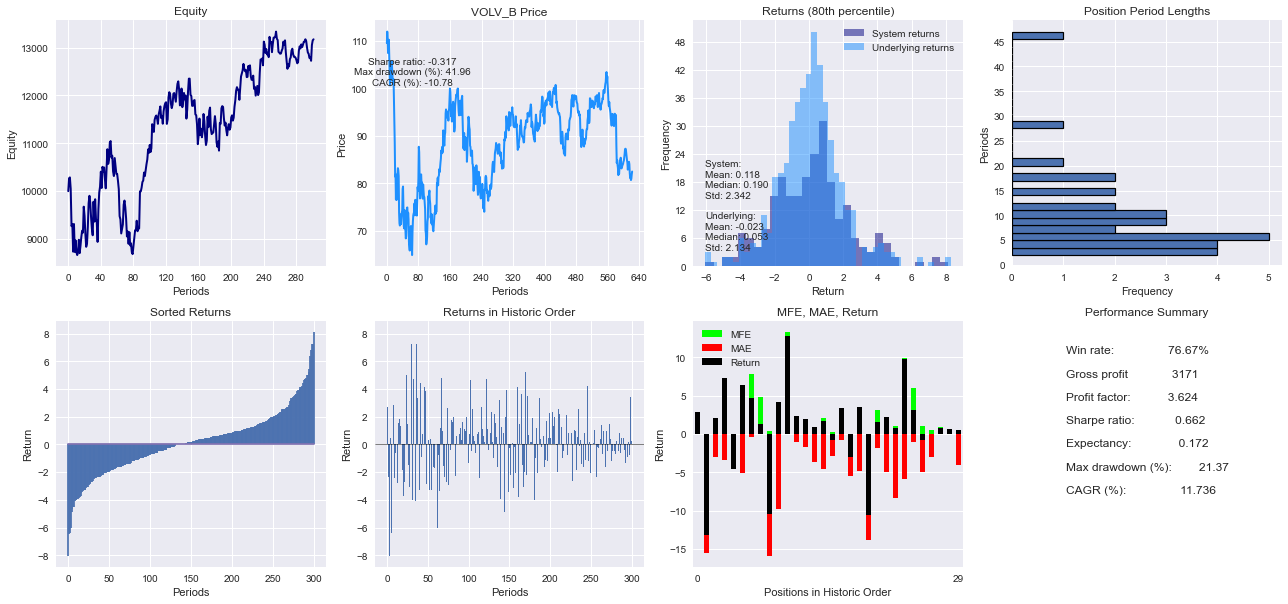


System performance summary: 
       Symbol Number of positions Start capital Final capital Total gross profit Avg pos net profit     % wins Profit factor  Sharpe ratio  Rate of return  Mean P/L  Median P/L  Std of P/L  Mean return  Median return  Std of returns  Expectancy  Avg MAE  Min MAE  Avg MFE  Max MFE  Max drawdown (%)  RoMad  CAGR (%)
0       SAND                  18         10000         14027               4027            223.592  72.222222         2.880         0.803           40.27     1.756       2.675       5.739        2.252          2.745           6.263       0.421   -6.417   -24.52    4.626    11.83         26.615527  1.513    14.608
1      SHB_A                  16         10000         11946               1946            121.496  62.500000         1.772         1.063           19.46     0.727       0.615       2.247        1.217          1.055           3.627       0.463   -2.748   -16.06    3.082     7.28         17.449367  1.115     7.428
2      SCA_B            

In [109]:
INSTRUMENTS_DB = InstrumentsMongoDb('mongodb://localhost:27017/', 'instruments_db')
SYSTEMS_DB = TetSystemsMongoDb('mongodb://localhost:27017/', 'systems_db')

symbols_list = json.loads(INSTRUMENTS_DB.get_omxs30_instruments())
benchmark_symbol = '^OMX'
start_dt = dt.datetime(2004, 1, 1)
end_dt = dt.datetime(2014, 1, 1)

data_dict = {
    symbol: pd.json_normalize(
        price_data_get_req(symbol, start_dt, end_dt)['data']
    )
    for symbol in symbols_list
}

df_benchmark = pd.json_normalize(
    price_data_get_req(benchmark_symbol, start_dt, end_dt)['data']
)

target_period = 3
entry_args = {
    'req_period_iters': target_period, 'entry_period_param': target_period
}
exit_args = {
    'exit_period_param': target_period
}

data_dict = preprocess_data(data_dict, df_benchmark)

models_data_dict = create_regression_models(data_dict, target_period=target_period)

pos_sizer = ExtPositionSizer('sharpe_ratio')
ts = TradingSystem(
    'example_system', models_data_dict, regression_entry_func, regression_exit_func,
    pos_sizer
)
ts(
    entry_args=entry_args, exit_args=exit_args,
    plot_performance_summary=True
)